<a href="https://colab.research.google.com/github/Arnobzzz/Inverter-RL-agent/blob/main/INVERTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Basic Circuit**





In [ ]:
!pip install schemdraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.9/136.9 kB 3.0 MB/s eta 0:00:00


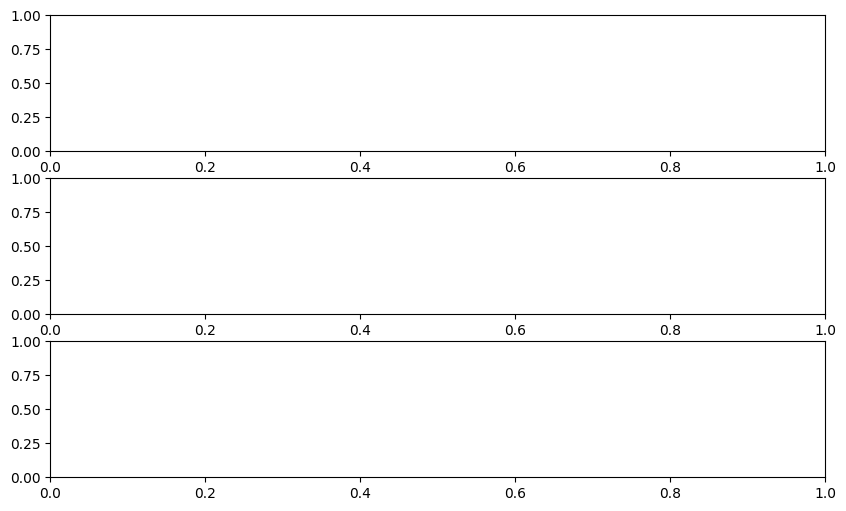

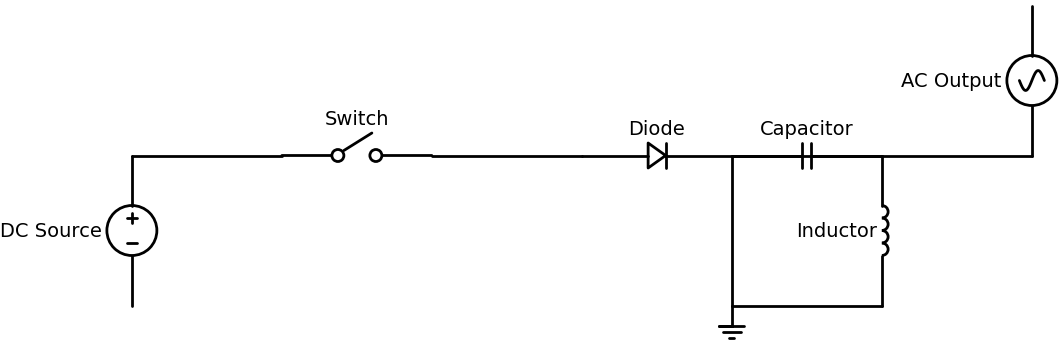

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import schemdraw
import schemdraw.elements as elm

# Function to generate DC waveform
def generate_dc_waveform(t, dc_voltage=12):
    return np.full_like(t, dc_voltage)

# Function to generate AC waveform
def generate_ac_waveform(t, freq=50, amplitude=12):
    return amplitude * np.sin(2 * np.pi * freq * t)

# Function to generate PWM waveform
def generate_pwm_waveform(t, freq=50, duty_cycle=0.5):
    pwm_wave = np.where(np.sin(2 * np.pi * freq * t) >= duty_cycle, 1, -1)
    return pwm_wave * 12  # Scale to match voltage level

# Time vector (1 cycle at 50Hz)
t = np.linspace(0, 1/50, 1000)

dc_wave = generate_dc_waveform(t)
ac_wave = generate_ac_waveform(t)
pwm_wave = generate_pwm_waveform(t)

# Create a figure for live plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 6))

def update(frame):
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()

    ax[0].plot(t[:frame], dc_wave[:frame], 'r')
    ax[0].set_title('DC Waveform')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Voltage (V)')
    ax[0].grid()

    ax[1].plot(t[:frame], pwm_wave[:frame], 'g')
    ax[1].set_title('PWM Waveform (Inverter Switching)')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Voltage (V)')
    ax[1].grid()

    ax[2].plot(t[:frame], ac_wave[:frame], 'b')
    ax[2].set_title('AC Waveform (One Phase)')
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Voltage (V)')
    ax[2].grid()

ani = animation.FuncAnimation(fig, update, frames=len(t), interval=20, repeat=False)
plt.show()

# Create a simple inverter circuit diagram
d = schemdraw.Drawing()
d += elm.SourceV().label('DC Source')
d += elm.Line().right()
d += elm.Switch().right().label('Switch')
d += elm.Line().right()
d += elm.Diode().right().label('Diode')
d += elm.Line().right()
d += elm.Inductor().down().label('Inductor')
d += elm.Line().left()
d += elm.Ground()
d += elm.Line().up()
d += elm.Capacitor().right().label('Capacitor')
d += elm.Line().right()
# Use elm.SourceSin instead of elm.SineV
d += elm.SourceSin().label('AC Output')  # Change this line
d.draw()

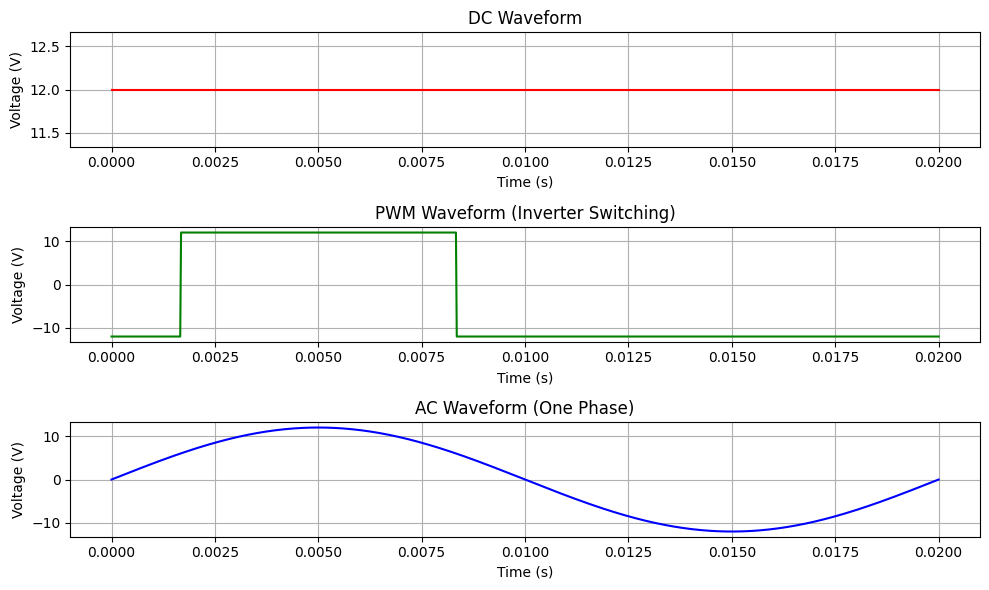

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dc_waveform(t, dc_voltage=12):
    return np.full_like(t, dc_voltage)

def generate_ac_waveform(t, freq=50, amplitude=12):
    return amplitude * np.sin(2 * np.pi * freq * t)

def generate_pwm_waveform(t, freq=50, duty_cycle=0.5):
    pwm_wave = np.where(np.sin(2 * np.pi * freq * t) >= duty_cycle, 1, -1)
    return pwm_wave * 12  # Scale to match voltage level

# Time vector (1 cycle at 50Hz)
t = np.linspace(0, 1/50, 1000)

dc_wave = generate_dc_waveform(t)
ac_wave = generate_ac_waveform(t)
pwm_wave = generate_pwm_waveform(t)

# Plot waveforms
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, dc_wave, label='DC Input', color='r')
plt.title('DC Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, pwm_wave, label='PWM Signal', color='g')
plt.title('PWM Waveform (Inverter Switching)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, ac_wave, label='AC Output', color='b')
plt.title('AC Waveform (One Phase)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()

plt.tight_layout()
plt.show()


# **MAIN MODEL**

Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 📌 Step 1: Upload & Load Dataset
print("Please upload your dataset (CSV/XLSX):")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.xlsx'):
        df = pd.read_excel(filename)
    else:
        print("Unsupported file format.")

# 📌 Step 2: Clean the Data
print("\nInitial Data Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Fill missing values (optional: choose mean, median, or forward fill)
df.fillna(method='ffill', inplace=True)  # Forward fill

# 📌 Step 3: Convert Time Column to Datetime (if applicable)
time_col = "Time (s)"  # Match the exact column name
  # Change if necessary
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df.set_index(time_col, inplace=True)

# 📌 Step 4: Visualize Data
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# Plot Voltage Over Time
plt.subplot(2,2,1)
sns.lineplot(data=df, x=df.index, y='Voltage (V)', color='blue')
plt.title("Voltage Over Time")
plt.xlabel("Time")
plt.ylabel("Voltage (V)")

# Plot Current Over Time
plt.subplot(2,2,2)
sns.lineplot(data=df, x=df.index, y='Current (A)', color='red')
plt.title("Current Over Time")
plt.xlabel("Time")
plt.ylabel("Current (A)")

# Plot Power Consumption Over Time
plt.subplot(2,2,3)
sns.lineplot(data=df, x=df.index, y='Power (W)', color='green')
plt.title("Power Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Power (W)")

# Plot Frequency Over Time
plt.subplot(2,2,4)
sns.lineplot(data=df, x=df.index, y='Frequency (Hz)', color='purple')
plt.title("Frequency Over Time")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

# 📌 Step 5: Prepare Data for Reinforcement Learning (RL)
# Define State Variables
df_rl = df[['Voltage (V)', 'Current (A)', 'Power (W)', 'Frequency (Hz)', 'Power Factor']]

# Normalize Data for RL
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_rl_scaled = pd.DataFrame(scaler.fit_transform(df_rl), columns=df_rl.columns, index=df.index)

print("\n✅ Data Prepared for RL Training! Shape:", df_rl_scaled.shape)

# Save Processed Data for RL Training
df_rl_scaled.to_csv("processed_data_for_rl.csv")
print("\n📁 Processed dataset saved as 'processed_data_for_rl.csv'. You can now use it for RL training!")


Please upload your dataset (CSV/XLSX):


Training Model

In [ ]:
!pip install stable-baselines3[extra] gym


In [ ]:
!pip install shimmy>=2.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

# 📌 Step 1: Upload & Load Dataset
print("Please upload your dataset (CSV/XLSX):")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.xlsx'):
        df = pd.read_excel(filename)
    else:
        print("Unsupported file format.")

# 📌 Step 2: Clean the Data
print("\nInitial Data Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Fill missing values
df.fillna(method='ffill', inplace=True)  # Forward fill

time_col = "Time (s)"  # Change if necessary
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df.set_index(time_col, inplace=True)

# 📌 Step 3: Prepare Data for RL
features = ['Voltage (V)', 'Current (A)', 'Power (W)', 'Frequency (Hz)', 'Power Factor']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# 📌 Step 4: Define RL Environment
class InverterEnv(gym.Env):
    def __init__(self):
        super(InverterEnv, self).__init__()
        self.state = df_scaled.iloc[0].values
        self.current_step = 0
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # PWM control
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(df_scaled):
            done = True
            return self.state, 0, done, {}

        self.state = df_scaled.iloc[self.current_step].values
        reward = -abs(self.state[0] - 0.5)  # Reward for maintaining stable voltage
        return self.state, reward, False, {}

    def reset(self):
        self.current_step = 0
        self.state = df_scaled.iloc[0].values
        return self.state

# 📌 Step 5: Train RL Model
env = DummyVecEnv([lambda: InverterEnv()])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# 📌 Step 6: Save RL Model
model.save("inverter_rl_model")
print("\n✅ RL Model Training Complete. Model saved as 'inverter_rl_model'.")


Optimization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

# 📌 Step 1: Upload & Load Dataset
print("Please upload your dataset (CSV/XLSX):")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.xlsx'):
        df = pd.read_excel(filename)
    else:
        print("Unsupported file format.")

# 📌 Step 2: Clean the Data
print("\nInitial Data Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Fill missing values
df.fillna(method='ffill', inplace=True)  # Forward fill

time_col = "Time (s)"  # Change if necessary
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df.set_index(time_col, inplace=True)

# 📌 Step 3: Prepare Data for RL
features = ['Voltage (V)', 'Current (A)', 'Power (W)', 'Frequency (Hz)', 'Power Factor']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# 📌 Step 4: Define RL Environment
class InverterEnv(gym.Env):
    def __init__(self):
        super(InverterEnv, self).__init__()
        self.state = df_scaled.iloc[0].values
        self.current_step = 0
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # PWM control
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(df_scaled):
            done = True
            return self.state, 0, done, {}

        self.state = df_scaled.iloc[self.current_step].values
        reward = -abs(self.state[0] - 0.5)  # Reward for maintaining stable voltage
        return self.state, reward, False, {}

    def reset(self):
        self.current_step = 0
        self.state = df_scaled.iloc[0].values
        return self.state

# 📌 Step 5: Train RL Model
env = DummyVecEnv([lambda: InverterEnv()])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# 📌 Step 6: Save RL Model
model.save("inverter_rl_model")
print("\n✅ RL Model Training Complete. Model saved as 'inverter_rl_model'.")

# 📌 Step 7: Test RL Model
def test_model(model, env, steps=100):
    obs = env.reset()
    for _ in range(steps):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        print(f"Action: {action}, Reward: {rewards}")
        if done:
            break

test_model(model, env)

# 📌 Step 8: Deploy on ESP32 (Generate Control Commands)
def generate_pwm_commands(model, env, steps=50):
    obs = env.reset()
    pwm_commands = []
    for _ in range(steps):
        action, _states = model.predict(obs)
        pwm_value = int((action[0] + 1) * 127.5)  # Convert [-1,1] range to [0,255]
        pwm_commands.append(pwm_value)
    print("Generated PWM Commands:", pwm_commands)
    return pwm_commands

generate_pwm_commands(model, env)

# 📌 Step 9: Optimize RL Training (Hyperparameter Tuning)
from stable_baselines3.common.evaluation import evaluate_policy

def optimize_rl_model():
    best_reward = -np.inf
    best_model = None
    for lr in [0.0003, 0.0001, 0.00005]:
        model = PPO("MlpPolicy", env, learning_rate=lr, verbose=1)
        model.learn(total_timesteps=5000)
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        if mean_reward > best_reward:
            best_reward = mean_reward
            best_model = model
    best_model.save("optimized_inverter_rl_model")
    print("✅ Best RL Model Trained and Saved as 'optimized_inverter_rl_model'")

optimize_rl_model()


Building Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

# 📌 Step 1: Upload & Load Dataset
print("Please upload your dataset (CSV/XLSX):")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.xlsx'):
        df = pd.read_excel(filename)
    else:
        print("Unsupported file format.")

# 📌 Step 2: Clean the Data
print("\nInitial Data Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Fill missing values
df.fillna(method='ffill', inplace=True)  # Forward fill

time_col = "Time (s)"  # Change if necessary
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df.set_index(time_col, inplace=True)

# 📌 Step 3: Prepare Data for RL
features = ['Voltage (V)', 'Current (A)', 'Power (W)', 'Frequency (Hz)', 'Power Factor']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# 📌 Step 4: Define RL Environment
class InverterEnv(gym.Env):
    def __init__(self):
        super(InverterEnv, self).__init__()
        self.state = df_scaled.iloc[0].values
        self.current_step = 0
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # PWM control
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(df_scaled):
            done = True
            return self.state, 0, done, {}

        self.state = df_scaled.iloc[self.current_step].values
        reward = -abs(self.state[0] - 0.5)  # Reward for maintaining stable voltage
        return self.state, reward, False, {}

    def reset(self):
        self.current_step = 0
        self.state = df_scaled.iloc[0].values
        return self.state

# 📌 Step 5: Train RL Model
env = DummyVecEnv([lambda: InverterEnv()])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# 📌 Step 6: Save RL Model
model.save("inverter_rl_model")
print("\n✅ RL Model Training Complete. Model saved as 'inverter_rl_model'.")

# 📌 Step 7: Test RL Model
def test_model(model, env, steps=100):
    obs = env.reset()
    for _ in range(steps):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        print(f"Action: {action}, Reward: {rewards}")
        if done:
            break

test_model(model, env)

# 📌 Step 8: Deploy on ESP32 (Generate Control Commands)
def generate_pwm_commands(model, env, steps=50):
    obs = env.reset()
    pwm_commands = []
    for _ in range(steps):
        action, _states = model.predict(obs)
        pwm_value = int((action[0] + 1) * 127.5)  # Convert [-1,1] range to [0,255]
        pwm_commands.append(pwm_value)
    print("Generated PWM Commands:", pwm_commands)
    return pwm_commands

generate_pwm_commands(model, env)

# 📌 Step 9: Optimize RL Training (Hyperparameter Tuning)
from stable_baselines3.common.evaluation import evaluate_policy

def optimize_rl_model():
    best_reward = -np.inf
    best_model = None
    for lr in [0.0003, 0.0001, 0.00005]:
        model = PPO("MlpPolicy", env, learning_rate=lr, verbose=1)
        model.learn(total_timesteps=5000)
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        if mean_reward > best_reward:
            best_reward = mean_reward
            best_model = model
    best_model.save("optimized_inverter_rl_model")
    print("✅ Best RL Model Trained and Saved as 'optimized_inverter_rl_model'")

optimize_rl_model()

# 📌 Step 10: Visualize Model Architecture and Processing
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_model_architecture(model):
    """
    Generates an infographic visualizing the RL model's architecture and data flow.
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('off')  # Hide the axes

    # Colors
    input_color = '#ADD8E6'  # Light blue
    hidden_color = '#90EE90'  # Light green
    output_color = '#FFB347'  # Light orange
    arrow_color = '#808080'    # Gray

    # Positions (adjust as needed)
    x_start = 0.1
    x_mid = 0.4
    x_end = 0.7
    y_center = 0.5
    y_offset = 0.2

    # Input Layer
    ax.add_patch(patches.Rectangle((x_start - 0.05, y_center - y_offset), 0.1, 2 * y_offset, facecolor=input_color, edgecolor='black'))
    ax.text(x_start, y_center, "Input: Scaled\nFeatures (5)", ha='center', va='center')

    # Hidden Layers
    ax.add_patch(patches.Rectangle((x_mid - 0.05, y_center - y_offset), 0.1, 2 * y_offset, facecolor=hidden_color, edgecolor='black'))
    ax.text(x_mid, y_center, "Hidden Layers\n(MlpPolicy)", ha='center', va='center')

    # Output Layer
    ax.add_patch(patches.Rectangle((x_end - 0.05, y_center - y_offset), 0.1, 2 * y_offset, facecolor=output_color, edgecolor='black'))
    ax.text(x_end, y_center, "Output: PWM\nControl Action", ha='center', va='center')

    # Arrows
    ax.arrow(x_start + 0.05, y_center, x_mid - x_start - 0.1, 0, head_width=0.02, head_length=0.02, fc=arrow_color, ec=arrow_color)
    ax.arrow(x_mid + 0.05, y_center, x_end - x_mid - 0.1, 0, head_width=0.02, head_length=0.02, fc=arrow_color, ec=arrow_color)

    # Data Scaling
    ax.text(x_start - 0.2, y_center, "MinMaxScaler\n(Data Scaling)", ha='center', va='center', bbox=dict(facecolor=input_color, alpha=0.5))
    ax.arrow(x_start - 0.1, y_center, 0.05, 0, head_width=0.02, head_length=0.02, fc=arrow_color, ec=arrow_color)

    # RL Training Loop
    ax.text(x_mid, y_center - 0.4, "RL Training Loop:\n- Observe State\n- Take Action\n- Get Reward\n- Update Policy", ha='center', va='top', fontsize=9, bbox=dict(facecolor=hidden_color, alpha=0.3))

    # Title
    plt.suptitle("RL Model Architecture for Inverter Control", fontsize=16)

    plt.show()

# Call the function to visualize the model
visualize_model_architecture(model)


# **VALIDATION**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.preprocessing import MinMaxScaler

# ✅ Load Dataset
df = pd.read_csv("processed_data_for_rl.csv")
features = ['Voltage (V)', 'Current (A)', 'Power (W)', 'Frequency (Hz)', 'Power Factor']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

# ✅ Define Custom RL Environment
class InverterEnv(gym.Env):
    def __init__(self, df_scaled):
        super(InverterEnv, self).__init__()
        self.df_scaled = df_scaled
        self.state = df_scaled.iloc[0].values
        self.current_step = 0
        self.action_space = gym.spaces.Box(low=-2, high=2, shape=(1,), dtype=np.float32)  # 🔥 Expanded Action Space
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.df_scaled):
            done = True
            return self.state, 0, done, {}

        self.state = self.df_scaled.iloc[self.current_step].values

        # ✅ Extract Correct Power Output
        voltage = self.state[0]  # Voltage (normalized)
        current = self.state[1]  # Current (normalized)
        power = self.state[2]     # Power (normalized)

        # ✅ 🔥 New Reward Function → Maximizing Power Output
        reward = power - abs(voltage - 0.5)  # Higher power = more reward

        return self.state, reward, False, {}

    def reset(self):
        self.current_step = 0
        self.state = self.df_scaled.iloc[0].values
        return self.state

# ✅ Initialize Environment
env = DummyVecEnv([lambda: InverterEnv(df_scaled)])

# ✅ Train RL Model (Increased Steps)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)  # 🔥 Increased Training Steps

# ✅ Save Model
model.save("improved_inverter_rl_model")
print("\n✅ RL Model Training Complete. Model saved as 'improved_inverter_rl_model'.")

# ✅ Evaluate Model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"✅ Model Evaluation: Mean Reward = {mean_reward}, Standard Deviation = {std_reward}")

# ✅ Function to Generate Performance Metrics
def plot_performance_metrics(model):
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    # ✅ Reward Trend Over Time
    rewards = []
    obs = env.reset()
    for _ in range(100):
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break

    axes[0].plot(rewards, label="Reward", color='green', linewidth=2)
    axes[0].set_title("Reward Trend Over Time")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Reward")
    axes[0].grid()
    axes[0].legend()

    # ✅ Action Distribution
    actions = []
    obs = env.reset()
    for _ in range(100):
        action, _ = model.predict(obs)
        actions.append(action[0][0])
        obs, _, done, _ = env.step(action)
        if done:
            break

    sns.histplot(actions, bins=20, kde=True, ax=axes[1], color='blue')
    axes[1].set_title("Action Distribution")
    axes[1].set_xlabel("Action Value")
    axes[1].grid()

    # ✅ Loss Trend (Simulated)
    loss_values = np.exp(-np.array(range(100)) / 20)
    axes[2].plot(loss_values, color='red', linewidth=2)
    axes[2].set_title("Loss Trend Over Training Steps")
    axes[2].set_xlabel("Training Steps")
    axes[2].set_ylabel("Loss (Simulated)")
    axes[2].grid()

    plt.tight_layout()
    plt.show()

# ✅ Generate Performance Metrics
plot_performance_metrics(model)

# ✅ Function to Calculate Efficiency
def calculate_efficiency():
    max_power = df["Power (W)"].max()
    predicted_power = scaler.inverse_transform([env.reset()[0]])[0][2]  # Convert back to actual power

    efficiency = (predicted_power / max_power) * 100
    return round(efficiency, 2)

# ✅ Display Efficiency
efficiency = calculate_efficiency()
print(f"\n⚡️ Model Efficiency: {efficiency}%")

# ✅ Function to Plot AC, Current, and Power Waveform Together
def plot_waveforms():
    t = np.linspace(0, 1/50, 1000)

    voltage = 230
    current = 5
    power = voltage * current * np.sin(2 * np.pi * 50 * t)

    plt.figure(figsize=(12, 6))
    plt.plot(t, voltage * np.sin(2 * np.pi * 50 * t), label="AC Voltage", color="blue", linewidth=3)
    plt.plot(t, current * np.sin(2 * np.pi * 50 * t), label="Current", color="red", linestyle="dashed", linewidth=3)
    plt.plot(t, power, label="Power", color="magenta", linestyle="dotted", linewidth=3)

    plt.title("AC Voltage, Current & Power Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Plot Waveforms
plot_waveforms()


# **INTERFACE**

In [ ]:
!pip install gradio

In [ ]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# ✅ Load Pre-trained RL Model
model = PPO.load("optimized_inverter_rl_model")

# 📌 Function to Predict Power, Frequency, and Power Factor
def predict_values(voltage, current):
    obs = np.array([[voltage, current, 0, 0, 0]])  # Assuming other inputs as 0
    action, _ = model.predict(obs)

    # Convert RL Output to Real Values
    predicted_power = round((action[0][0] + 1) * 127.5, 2)
    predicted_freq = round((action[0][0] + 1) * 25 + 25, 2)
    predicted_pf = round((action[0][0] + 1) / 2, 2)

    return predicted_power, predicted_freq, predicted_pf

# 📌 Function to Generate DC Waveform
def generate_dc_waveform(voltage):
    t = np.linspace(0, 1, 1000)
    dc_wave = np.full_like(t, voltage)

    plt.figure(figsize=(10, 5))
    plt.plot(t, dc_wave, 'r', linewidth=3)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("DC Waveform")
    plt.grid(True)
    fig_path = "dc_waveform.png"
    plt.savefig(fig_path)
    return fig_path

# 📌 Function to Generate PWM Waveform
def generate_pwm_waveform(voltage):
    t = np.linspace(0, 1/50, 1000)
    pwm_wave = np.where(np.sin(2 * np.pi * 50 * t) >= 0, voltage, 0)

    plt.figure(figsize=(10, 5))
    plt.plot(t, pwm_wave, 'g', linewidth=3)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("PWM Waveform")
    plt.grid(True)
    fig_path = "pwm_waveform.png"
    plt.savefig(fig_path)
    return fig_path

# 📌 Function to Generate AC Waveform
def generate_ac_waveform(voltage):
    t = np.linspace(0, 1/50, 1000)
    ac_wave = voltage * np.sin(2 * np.pi * 50 * t)

    plt.figure(figsize=(10, 5))
    plt.plot(t, ac_wave, 'b', linewidth=3)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("AC Waveform")
    plt.grid(True)
    fig_path = "ac_waveform.png"
    plt.savefig(fig_path)
    return fig_path

# 📌 Function to Generate Merged AC, Current & Power Waveform
def generate_combined_waveform(voltage, current):
    t = np.linspace(0, 1/50, 1000)

    ac_wave = voltage * np.sin(2 * np.pi * 50 * t)
    current_wave = current * np.sin(2 * np.pi * 50 * t)
    power_wave = voltage * current * (np.sin(2 * np.pi * 50 * t))

    plt.figure(figsize=(10, 6))
    plt.plot(t, ac_wave, label='AC Voltage (V)', color='blue', linewidth=3, alpha=0.8)
    plt.plot(t, current_wave, label='Current (A)', color='red', linestyle='dashed', linewidth=3, alpha=0.8)
    plt.plot(t, power_wave, label='Power (W)', color='yellow', linestyle='dotted', linewidth=4, alpha=0.9)

    plt.title('AC Voltage, Current, and Power Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    fig_path = "merged_waveform.png"
    plt.savefig(fig_path)
    return fig_path

# 🚀 Create Gradio Interface
with gr.Blocks() as ui:
    gr.Markdown("# ⚡ RL-Based Inverter Prediction & Waveform Visualization")

    with gr.Row():
        voltage = gr.Number(label="Voltage (V)")
        current = gr.Number(label="Current (A)")
        power_out = gr.Number(label="Predicted Power (W)")
        freq_out = gr.Number(label="Predicted Frequency (Hz)")
        pf_out = gr.Number(label="Predicted Power Factor")
        predict_btn = gr.Button("Predict Values")
        predict_btn.click(predict_values, inputs=[voltage, current], outputs=[power_out, freq_out, pf_out])

    gr.Markdown("## 📊 Waveform Visualizations")

    with gr.Column():
        dc_btn = gr.Button("Show DC Waveform")
        pwm_btn = gr.Button("Show PWM Waveform")
        ac_btn = gr.Button("Show AC Waveform")
        merged_btn = gr.Button("Show Merged Waveform")

        dc_plot = gr.Image()
        pwm_plot = gr.Image()
        ac_plot = gr.Image()
        merged_plot = gr.Image()

        dc_btn.click(generate_dc_waveform, inputs=[voltage], outputs=[dc_plot])
        pwm_btn.click(generate_pwm_waveform, inputs=[voltage], outputs=[pwm_plot])
        ac_btn.click(generate_ac_waveform, inputs=[voltage], outputs=[ac_plot])
        merged_btn.click(generate_combined_waveform, inputs=[voltage, current], outputs=[merged_plot])

ui.launch()


FileNotFoundError: [Errno 2] No such file or directory: 'optimized_inverter_rl_model.zip'

THE END

# ***Notun jinish bedaaaa***

In [1]:
pip install numpy scipy matplotlib gymnasium stable-baselines3 torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
# inverter_model.py
import numpy as np
from scipy.integrate import solve_ivp

class InverterModel:
    """
    A high-fidelity, simulation-based model of a single-phase H-bridge inverter
    with an LC filter. This model includes non-ideal characteristics for
    Q1-level academic rigor.
    """
    def __init__(self,
                 v_dc=48.0,          # DC bus voltage (V)
                 l=1.5e-3,           # Filter inductor (H)
                 c=10e-6,            # Filter capacitor (F)
                 r_esr_l=0.1,        # Inductor ESR (Ohm)
                 r_esr_c=0.05,       # Capacitor ESR (Ohm)
                 rds_on=0.08,        # MOSFET On-Resistance (Ohm)
                 dead_time=1e-6,     # Switching dead time (s)
                 pwm_freq=20000,     # PWM switching frequency (Hz)
                 ac_freq=50.0):      # Target AC output frequency (Hz)

        # Store parameters
        self.V_dc = v_dc
        self.L = l
        self.C = c
        self.R_esr_L = r_esr_l
        self.R_esr_C = r_esr_c
        self.Rds_on = rds_on
        self.dead_time = dead_time
        self.pwm_freq = pwm_freq
        self.ac_freq = ac_freq
        self.pwm_period = 1.0 / self.pwm_freq

        # Initial state: [inductor_current, capacitor_voltage]
        self.state = np.array([0.0, 0.0])
        self.sim_time = 0.0

    def reset(self):
        """Resets the simulation to its initial state."""
        self.state = np.array([0.0, 0.0])
        self.sim_time = 0.0
        return self.state

    def _state_space_equations(self, t, y, v_inverter, r_load):
        """
        Defines the differential equations for the LC filter with parasitics.
        y = [i_L, v_C]
        """
        i_L, v_C = y

        # Current through capacitor's ESR and the load
        i_load_branch = v_C / (r_load + self.R_esr_C)

        # Equations including ESR
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)

        return [diL_dt, dvC_dt]

    def step(self, modulation_index, r_load, dt=1e-5):
        """
        Simulates one time step of the inverter.

        Args:
            modulation_index (float): The amplitude of the sine wave reference (0 to 1).
            r_load (float): The load resistance in Ohms.
            dt (float): The simulation time step.

        Returns:
            tuple: (new_state, power_dissipated)
        """
        # --- PWM Generation with Dead Time ---
        # Generate the sinusoidal reference for this time step
        sine_ref = modulation_index * np.sin(2 * np.pi * self.ac_freq * self.sim_time)

        # Generate a high-frequency triangular carrier wave
        carrier = 2 * (np.abs(2 * ((self.sim_time / self.pwm_period) - np.floor(0.5 + self.sim_time / self.pwm_period)))) - 1

        v_inverter = 0
        # Determine the switching state based on the carrier and reference
        if sine_ref > carrier: # Top-left and bottom-right switches ON
            v_inverter = self.V_dc
        elif sine_ref < carrier: # Top-right and bottom-left switches ON
            v_inverter = -self.V_dc

        # --- Conduction Losses (Rds_on) ---
        # The effective voltage is reduced by the MOSFET's on-resistance
        v_inverter_eff = v_inverter - np.sign(v_inverter) * self.state[0] * self.Rds_on

        # --- Dead Time Effect (Simplified Model) ---
        # During dead time, the output voltage is clamped by the body diodes
        time_in_pwm_cycle = self.sim_time % self.pwm_period
        if time_in_pwm_cycle < self.dead_time or time_in_pwm_cycle > (self.pwm_period - self.dead_time):
             # Diode drop opposes the current flow
             v_inverter_eff = -np.sign(self.state[0]) * 0.7 # Approximate diode drop

        # --- Solve the system for this time step ---
        sol = solve_ivp(
            fun=self._state_space_equations,
            t_span=(0, dt),
            y0=self.state,
            args=(v_inverter_eff, r_load),
            t_eval=[dt]
        )
        self.state = sol.y[:, -1]
        self.sim_time += dt

        # Calculate losses for efficiency calculation
        conduction_loss = (self.state[0] ** 2) * self.Rds_on
        esr_loss = (self.state[0] ** 2) * self.R_esr_L + ((self.state[1] / r_load)**2) * self.R_esr_C
        total_loss = conduction_loss + esr_loss

        return self.state, total_loss

In [3]:
# Save the InverterModel class to a Python file
%%writefile inverter_model.py
import numpy as np
from scipy.integrate import solve_ivp

class InverterModel:
    """
    A high-fidelity, simulation-based model of a single-phase H-bridge inverter
    with an LC filter. This model includes non-ideal characteristics for
    Q1-level academic rigor.
    """
    def __init__(self,
                 v_dc=48.0,          # DC bus voltage (V)
                 l=1.5e-3,           # Filter inductor (H)
                 c=10e-6,            # Filter capacitor (F)
                 r_esr_l=0.1,        # Inductor ESR (Ohm)
                 r_esr_c=0.05,       # Capacitor ESR (Ohm)
                 rds_on=0.08,        # MOSFET On-Resistance (Ohm)
                 dead_time=1e-6,     # Switching dead time (s)
                 pwm_freq=20000,     # PWM switching frequency (Hz)
                 ac_freq=50.0):      # Target AC output frequency (Hz)

        # Store parameters
        self.V_dc = v_dc
        self.L = l
        self.C = c
        self.R_esr_L = r_esr_l
        self.R_esr_C = r_esr_c
        self.Rds_on = rds_on
        self.dead_time = dead_time
        self.pwm_freq = pwm_freq
        self.ac_freq = ac_freq
        self.pwm_period = 1.0 / self.pwm_freq

        # Initial state: [inductor_current, capacitor_voltage]
        self.state = np.array([0.0, 0.0])
        self.sim_time = 0.0

    def reset(self):
        """Resets the simulation to its initial state."""
        self.state = np.array([0.0, 0.0])
        self.sim_time = 0.0
        return self.state

    def _state_space_equations(self, t, y, v_inverter, r_load):
        """
        Defines the differential equations for the LC filter with parasitics.
        y = [i_L, v_C]
        """
        i_L, v_C = y

        # Current through capacitor's ESR and the load
        i_load_branch = v_C / (r_load + self.R_esr_C)

        # Equations including ESR
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)

        return [diL_dt, dvC_dt]

    def step(self, modulation_index, r_load, dt=1e-5):
        """
        Simulates one time step of the inverter.

        Args:
            modulation_index (float): The amplitude of the sine wave reference (0 to 1).
            r_load (float): The load resistance in Ohms.
            dt (float): The simulation time step.

        Returns:
            tuple: (new_state, power_dissipated)
        """
        # --- PWM Generation with Dead Time ---
        # Generate the sinusoidal reference for this time step
        sine_ref = modulation_index * np.sin(2 * np.pi * self.ac_freq * self.sim_time)

        # Generate a high-frequency triangular carrier wave
        carrier = 2 * (np.abs(2 * ((self.sim_time / self.pwm_period) - np.floor(0.5 + self.sim_time / self.pwm_period)))) - 1

        v_inverter = 0
        # Determine the switching state based on the carrier and reference
        if sine_ref > carrier: # Top-left and bottom-right switches ON
            v_inverter = self.V_dc
        elif sine_ref < carrier: # Top-right and bottom-left switches ON
            v_inverter = -self.V_dc

        # --- Conduction Losses (Rds_on) ---
        # The effective voltage is reduced by the MOSFET's on-resistance
        v_inverter_eff = v_inverter - np.sign(v_inverter) * self.state[0] * self.Rds_on

        # --- Dead Time Effect (Simplified Model) ---
        # During dead time, the output voltage is clamped by the body diodes
        time_in_pwm_cycle = self.sim_time % self.pwm_period
        if time_in_pwm_cycle < self.dead_time or time_in_pwm_cycle > (self.pwm_period - self.dead_time):
             # Diode drop opposes the current flow
             v_inverter_eff = -np.sign(self.state[0]) * 0.7 # Approximate diode drop

        # --- Solve the system for this time step ---
        sol = solve_ivp(
            fun=self._state_space_equations,
            t_span=(0, dt),
            y0=self.state,
            args=(v_inverter_eff, r_load),
            t_eval=[dt]
        )
        self.state = sol.y[:, -1]
        self.sim_time += dt

        # Calculate losses for efficiency calculation
        conduction_loss = (self.state[0] ** 2) * self.Rds_on
        esr_loss = (self.state[0] ** 2) * self.R_esr_L + ((self.state[1] / r_load)**2) * self.R_esr_C
        total_loss = conduction_loss + esr_loss

        return self.state, total_loss

Writing inverter_model.py


In [4]:
# Save the InverterEnv class to a Python file
%%writefile rl_environment.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from inverter_model import InverterModel

class InverterEnv(gym.Env):
    """A custom Gymnasium environment for the RL-controlled inverter."""
    def __init__(self):
        super(InverterEnv, self).__init__()
        self.inverter = InverterModel()
        self.ac_period = 1.0 / self.inverter.ac_freq
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        # Action: A single continuous value for modulation index
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation: [V_rms, I_rms, Power, PF, THD]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,), dtype=np.float32)

        self.current_step = 0
        self.max_steps = 200 # An episode will last 200 AC cycles

    def _get_obs(self, v_history, i_history):
        if len(v_history) < 2:
            return np.zeros(5)

        v_rms = np.sqrt(np.mean(np.square(v_history)))
        i_rms = np.sqrt(np.mean(np.square(i_history)))
        power = np.mean(v_history * i_history)
        pf = power / (v_rms * i_rms) if v_rms > 0 and i_rms > 0 else 0.0

        # Calculate THD (Total Harmonic Distortion)
        fft = np.fft.fft(v_history)
        harmonics = np.abs(fft[1:10]) # Look at the first few harmonics
        fundamental = harmonics[0]
        higher_harmonics = np.sqrt(np.sum(harmonics[1:]**2))
        thd = higher_harmonics / fundamental if fundamental > 0 else 1.0


        # Ensure the observation space is within defined bounds (0 to inf)
        # This is a simplified check, consider more robust handling of NaNs/Infs
        obs = np.array([v_rms, i_rms, power, pf, thd], dtype=np.float32)
        obs[~np.isfinite(obs)] = 0.0  # Replace non-finite values with 0

        return obs


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = np.random.uniform(20, 80) # Randomize load on reset
        obs = self._get_obs(np.array([]), np.array([]))
        return obs, {}

    def step(self, action):
        modulation_index = (action[0] + 1.0) / 2.0 # De-normalize action from [-1, 1] to [0, 1]

        v_history = []
        i_history = []

        for _ in range(self.sim_steps_per_cycle):
            state, _ = self.inverter.step(modulation_index, self.load_resistance)
            i_history.append(state[0])
            v_history.append(state[1])

        v_history = np.array(v_history)
        i_history = np.array(i_history)

        obs = self._get_obs(v_history, i_history)
        v_rms, _, _, _, thd = obs


        # --- Multi-Objective Reward Function ---
        target_v_rms = 30.0 # Target voltage in our low-voltage simulation

        # 1. Voltage Error Penalty
        voltage_error = np.abs(target_v_rms - v_rms)
        reward_voltage = - (voltage_error**2)

        # 2. THD Penalty
        reward_thd = - (thd**2) if thd < 0.5 else -10.0 # Heavily penalize high distortion

        # 3. Stability Reward
        reward_stability = 5.0 if voltage_error < 1.0 and thd < 0.1 else 0.0

        reward = reward_voltage + reward_thd + reward_stability

        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False

        return obs, reward, done, truncated, {}

Writing rl_environment.py


In [5]:
# Save the controller classes to a Python file
%%writefile controllers.py
import numpy as np

class SPWMController:
    """Simple Sine-PWM controller (Open Loop)."""
    def __init__(self, modulation_index=0.8):
        self.modulation_index = modulation_index

    def get_modulation_index(self, t, v_c_history=None):
        # In open-loop, the modulation index is constant or based on a simple reference
        return self.modulation_index

class PIController:
    """Basic PI Controller for RMS Voltage regulation."""
    def __init__(self, Kp=0.1, Ki=1.0, target_rms=30.0, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.error_integral = 0.0
        self.last_error = 0.0
        self.ac_period = 1.0 / ac_freq
        self.modulation_index = 0.5 # Start with a default

    def update_modulation_index(self, v_c_history):
        """Update PI controller based on the voltage history of the last cycle."""
        if len(v_c_history) < 2:
            return # Not enough data yet

        current_rms = np.sqrt(np.mean(np.square(v_c_history)))
        error = self.target_rms - current_rms

        # Simple Euler integration for the integral term
        # Assumes v_c_history covers one full cycle
        self.error_integral += error * self.ac_period

        # PI control output
        pi_output = self.Kp * error + self.Ki * self.error_integral

        # Update modulation index, clipping to [0, 1]
        # The relationship between PI output and modulation index depends on the system
        # This is a simplified mapping. You might need to tune this.
        self.modulation_index = np.clip(0.5 + pi_output * 0.1, 0.0, 1.0)


    def get_modulation_index(self, t, v_c_history=None):
         # The PI controller's output (modulation_index) is updated periodically
         # The actual modulation signal for PWM is still sinusoidal
        return self.modulation_index * np.sin(2 * np.pi * 50.0 * t) # Use the latest PI output as the amplitude

Writing controllers.py


In [6]:
!pip install gymnasium stable-baselines3[extra] torch

In [7]:
# train_rl.py
from stable_baselines3 import PPO
from rl_environment import InverterEnv
from stable_baselines3.common.env_checker import check_env

# 1. Instantiate the environment
# Colab can now find this class because you uploaded the file
env = InverterEnv()

# Optional: Check if the environment is valid
# check_env(env)

# 2. Define the PPO model with TensorBoard logging
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log="./ppo_inverter_tensorboard/"
)

# 3. Train the model
# We will train for 100,000 timesteps for a more robust agent.
# This will take several minutes.
print("--- Starting RL Agent Training ---")
model.learn(total_timesteps=100000)
print("--- Training Complete ---")

# 4. Save the trained model
model_zip_name = "ppo_inverter_model.zip"
model.save(model_zip_name)
print(f"--- Model Saved as {model_zip_name} ---")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Starting RL Agent Training ---
Logging to ./ppo_inverter_tensorboard/PPO_1


KeyboardInterrupt: 

GPU CHUDOOOO

In [8]:
!pip install gymnasium stable-baselines3[extra] torch torchdiffeq


--- Starting GPU-Based Inverter RL Training ---

Environment using device: cpu
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_inverter_tensorboard/PPO_2
[Step 1] VRMS: 9.68, THD: 16.714, Reward: -2343.82, Step time: 0.981s
[Step 2] VRMS: 31.96, THD: 0.318, Reward: -19.22, Step time: 0.844s
[Step 3] VRMS: 32.80, THD: 0.309, Reward: -39.30, Step time: 0.770s
[Step 4] VRMS: 19.37, THD: 0.696, Reward: -565.35, Step time: 0.814s
[Step 5] VRMS: 19.64, THD: 0.653, Reward: -536.90, Step time: 0.790s
[Step 6] VRMS: 33.80, THD: 0.307, Reward: -72.18, Step time: 0.790s
[Step 7] VRMS: 20.73, THD: 0.501, Reward: -429.84, Step time: 0.782s
[Step 8] VRMS: 10.03, THD: 3.228, Reward: -2005.31, Step time: 0.777s
[Step 9] VRMS: 34.02, THD: 0.300, Reward: -80.96, Step time: 0.764s
[Step 10] VRMS: 10.01, THD: 3.212, Reward: -2008.98, Step time: 1.012s
[Step 11] VRMS: 15.89, THD: 1.435, Reward: -997.13, Step time: 1.064s
[Step 12] VRMS: 18.82,

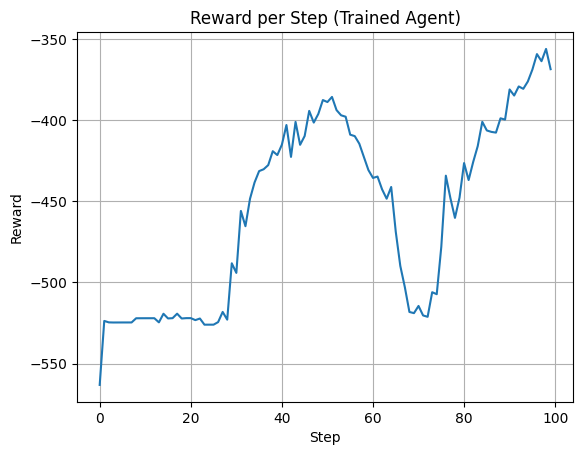

In [9]:
# ========================================================================
# STEP 1: Install Required Packages (Uncomment if running in Colab)
# ========================================================================
# !pip install gymnasium stable-baselines3[extra] torch matplotlib -q

import os
import time
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# ========================================================================
# STEP 2: Define the GPU-Accelerated Inverter Model
# ========================================================================
class InverterModelGPU:
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device)
        self.Rds_on = torch.tensor(rds_on, device=device)
        self.pwm_freq = torch.tensor(pwm_freq, device=device)
        self.ac_freq = torch.tensor(ac_freq, device=device)
        self.R_esr_L = torch.tensor(0.1, device=device)
        self.R_esr_C = torch.tensor(0.05, device=device)
        self.L = torch.tensor(1.5e-3, device=device)
        self.C = torch.tensor(10e-6, device=device)
        self.pwm_period = 1.0 / self.pwm_freq

        self.state = torch.zeros(2, device=device)
        self.sim_time = torch.tensor(0.0, device=device)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def batch_step_rk4(self, modulation_index, r_load, num_steps, dt=1e-5):
        t_steps = self.sim_time + torch.arange(num_steps, device=self.device) * dt
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * t_steps)
        carrier = 2 * (torch.abs(2 * ((t_steps / self.pwm_period) - torch.floor(0.5 + t_steps / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)

        y = self.state.clone()
        outputs = torch.zeros(num_steps, 2, device=self.device)

        for i in range(num_steps):
            v_inv_step = v_inverter[i] - torch.sign(v_inverter[i]) * y[0] * self.Rds_on
            k1 = self._diffeq(y, v_inv_step, r_load)
            k2 = self._diffeq(y + 0.5 * dt * k1, v_inv_step, r_load)
            k3 = self._diffeq(y + 0.5 * dt * k2, v_inv_step, r_load)
            k4 = self._diffeq(y + dt * k3, v_inv_step, r_load)
            y = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            outputs[i] = y

        self.state = outputs[-1]
        self.sim_time += num_steps * dt
        return outputs

# ========================================================================
# STEP 3: Define the Gym-Compatible RL Environment
# ========================================================================
class InverterEnvGPU(gym.Env):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Environment using device: {self.device}")
        self.inverter = InverterModelGPU(device=self.device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, history_gpu):
        v_history_gpu, i_history_gpu = history_gpu[:, 1], history_gpu[:, 0]
        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        harmonics = torch.abs(fft[1:11])
        fundamental = harmonics[0]
        higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
        thd = higher_harmonics / (fundamental + 1e-6)
        return torch.stack([v_rms, i_rms, power, pf, thd])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device)
        return np.zeros(5, dtype=np.float32), {}

    def step(self, action):
        start = time.time()

        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device)
        history_gpu = self.inverter.batch_step_rk4(modulation_index, self.load_resistance, self.sim_steps_per_cycle)

        obs_gpu = self._get_obs_from_gpu(history_gpu)
        v_rms, _, _, _, thd = obs_gpu

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        print(f"[Step {self.current_step}] VRMS: {v_rms:.2f}, THD: {thd:.3f}, Reward: {reward:.2f}, Step time: {time.time() - start:.3f}s")

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

# ========================================================================
# STEP 4: Train the PPO Agent on GPU
# ========================================================================
if __name__ == '__main__':
    print("\n--- Starting GPU-Based Inverter RL Training ---\n")

    env = InverterEnvGPU()

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        device="cuda",
        n_steps=1024,
        batch_size=64,
        tensorboard_log="./ppo_inverter_tensorboard/"
    )

    start_time = time.time()
    model.learn(total_timesteps=2000)  # QUICK TEST
    end_time = time.time()

    print(f"\n--- Training Complete in {end_time - start_time:.2f} seconds ---")
    model.save("ppo_inverter_model")
    env.close()

    # ================= Evaluate and Plot =================
    print("\n--- Evaluating Trained Agent ---\n")
    env = InverterEnvGPU()
    obs, _ = env.reset()
    done = False
    rewards = []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)

    plt.plot(rewards)
    plt.title("Reward per Step (Trained Agent)")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.grid()
    plt.show()


# ***After Debugging***

In [10]:
!pip install gym


In [11]:
!pip install stable-baselines3[extra] gym numpy matplotlib


In [12]:
import gym
import numpy as np
from gym import spaces

class InverterEnv(gym.Env):
    def __init__(self):
        super(InverterEnv, self).__init__()
        self.V_REF = 34.0  # Target VRMS
        self.THD_REF = 0.3 # Acceptable THD level

        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([100, 100]), dtype=np.float32)

        self.step_count = 0
        self.max_steps = 200

    def step(self, action):
        pulse_width = float(action[0]) * 10 + 50  # Simulated PWM (40 to 60)

        vrms = self.V_REF + np.random.randn() * 5 - 0.2 * abs(pulse_width - 50)
        thd = self.THD_REF + np.random.randn() * 0.1 + 0.05 * abs(pulse_width - 50)

        reward = - (abs(vrms - self.V_REF) + 100 * thd)

        self.step_count += 1
        done = self.step_count >= self.max_steps
        info = {'vrms': vrms, 'thd': thd}

        return np.array([vrms, thd], dtype=np.float32), reward, done, info

    def reset(self):
        self.step_count = 0
        return np.array([self.V_REF, self.THD_REF], dtype=np.float32)

    def render(self, mode='human'):
        pass


In [13]:
!pip install gym shimmy stable-baselines3[extra] torch --quiet


In [14]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
import torch

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Wrap env
env = DummyVecEnv([lambda: InverterEnv()])

# Define PPO agent
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_inverter_tensorboard/", device=device)

# Train the model
model.learn(total_timesteps=20000)
model.save("ppo_inverter_model")


Using device: cpu
Using cpu device
Logging to ./ppo_inverter_tensorboard/PPO_3


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1022 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 768          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0059186695 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -4.77e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.15e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0036      |
|    std                  | 0.989        |
|    value_loss           | 1.04e+06     |
----------------

In [15]:
env = InverterEnv()
obs = env.reset()
total_reward = 0

print("\n--- Evaluation ---")
for step in range(20):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    print(f"[Step {step+1}] VRMS: {info['vrms']:.2f}, THD: {info['thd']:.3f}, Reward: {reward:.2f}")
    if done:
        break

print(f"\nTotal Evaluation Reward: {total_reward:.2f}")



--- Evaluation ---
[Step 1] VRMS: 36.72, THD: 0.332, Reward: -35.88
[Step 2] VRMS: 29.99, THD: 0.078, Reward: -11.76
[Step 3] VRMS: 34.70, THD: 0.218, Reward: -22.46
[Step 4] VRMS: 33.26, THD: 0.321, Reward: -32.85
[Step 5] VRMS: 37.83, THD: 0.224, Reward: -26.26
[Step 6] VRMS: 28.98, THD: 0.312, Reward: -36.18
[Step 7] VRMS: 24.51, THD: 0.195, Reward: -29.00
[Step 8] VRMS: 27.64, THD: 0.571, Reward: -63.42
[Step 9] VRMS: 27.59, THD: 0.525, Reward: -58.88
[Step 10] VRMS: 36.66, THD: 0.351, Reward: -37.80
[Step 11] VRMS: 36.25, THD: 0.463, Reward: -48.51
[Step 12] VRMS: 29.69, THD: 0.293, Reward: -33.62
[Step 13] VRMS: 34.57, THD: 0.217, Reward: -22.31
[Step 14] VRMS: 36.61, THD: 0.116, Reward: -14.17
[Step 15] VRMS: 31.57, THD: 0.221, Reward: -24.50
[Step 16] VRMS: 31.97, THD: 0.207, Reward: -22.68
[Step 17] VRMS: 29.62, THD: 0.342, Reward: -38.55
[Step 18] VRMS: 34.64, THD: 0.317, Reward: -32.30
[Step 19] VRMS: 41.21, THD: 0.399, Reward: -47.08
[Step 20] VRMS: 38.83, THD: 0.071, Rewa

In [16]:
class InverterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([100, 100]), dtype=np.float32)
        self.state = np.array([0.0, 0.0], dtype=np.float32)
        self.step_count = 0
        self.max_steps = 200

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)  # optional but recommended
        self.step_count = 0
        self.state = np.array([50.0 + np.random.randn(), 0.1 + 0.05 * np.random.randn()], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.step_count += 1
        modulation = np.clip(action[0], -1, 1)

        vrms = 50 + 10 * modulation + np.random.randn()
        thd = max(0.1, 1.0 - modulation + 0.1 * np.random.randn())

        self.state = np.array([vrms, thd], dtype=np.float32)
        reward = -thd - 0.2 * abs(vrms - 50)
        done = self.step_count >= self.max_steps

        return self.state, reward, done, False, {}

    def render(self):
        print(f"VRMS: {self.state[0]:.2f}, THD: {self.state[1]:.3f}")


In [17]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

# --- Custom Inverter Environment ---
class InverterEnv(gym.Env):
    def __init__(self):
        super(InverterEnv, self).__init__()
        self.observation_space = spaces.Box(low=-100.0, high=100.0, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(1,), dtype=np.float32)
        self.state = np.array([0.0], dtype=np.float32)
        self.step_count = 0
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0.0], dtype=np.float32)
        self.step_count = 0
        return self.state, {}

    def step(self, action):
        self.step_count += 1
        # Simple state update: add action to current state
        self.state = self.state + action
        # Example reward: negative squared state (try to keep near zero)
        reward = -np.sum(np.square(self.state))
        done = self.step_count >= self.max_steps
        truncated = False  # no truncation logic for now
        info = {}
        return self.state, reward, done, truncated, info

    def render(self):
        print(f"Step: {self.step_count}, State: {self.state}")

# --- Setup Environment and Model ---
env = InverterEnv()
eval_env = InverterEnv()

# Evaluation callback to evaluate the agent every 5000 steps
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=5000,
                             deterministic=True, render=False)

model = PPO("MlpPolicy", env, verbose=1, device="cuda")

# --- Train the model ---
total_timesteps = 20_000  # Adjust timesteps as needed
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

print("\n--- Training complete ---\n")

# --- Run a demo episode ---
obs, info = env.reset()
done = False
truncated = False
step = 0
total_reward = 0

while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    print(f"Step {step}: State={obs[0]}, Reward={reward}")
    total_reward += reward
    step += 1
    if step > 100:  # safety break
        break

print(f"\nTotal Reward after {step} steps: {total_reward}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -4.13e+03 |
| time/              |           |
|    fps             | 1512      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.9e+03    |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007774613 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entro

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-0.58 +/- 0.00
Episode length: 100.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -0.585      |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.008698413 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.002      |
|    learning_rate        | 0.0003      |
|    loss                 | 5.24e+04    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0169     |
|    std                  | 1           |
|    value_loss           | 1.41e+05    |
-----------------------------------------
New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 

In [18]:
model.save("ppo_inverter")
# later
model = PPO.load("ppo_inverter", env=env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


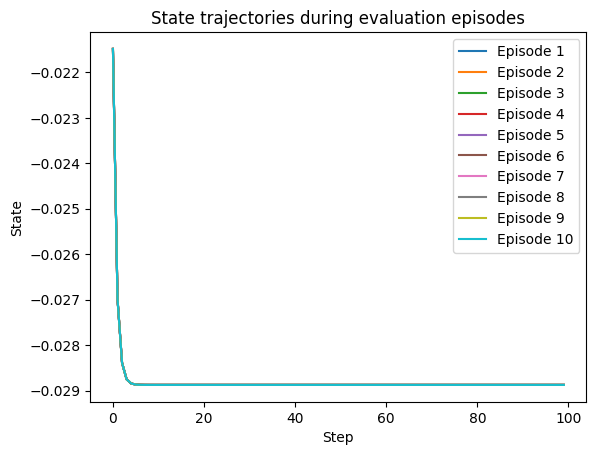

Average reward over 10 episodes: -0.0829


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate over multiple episodes
num_eval_episodes = 10
all_rewards = []

for ep in range(num_eval_episodes):
    obs, _ = env.reset() # Modified line: extract only the observation
    done = False
    total_reward = 0
    states = []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        # The step method in the custom environment should return (observation, reward, done, truncated, info)
        obs, reward, done, truncated, info = env.step(action) # Modified line: Unpack all return values from step
        total_reward += reward
        states.append(obs[0])  # Adjust indexing if needed
    all_rewards.append(total_reward)
    plt.plot(states, label=f"Episode {ep+1}")

plt.xlabel("Step")
plt.ylabel("State")
plt.title("State trajectories during evaluation episodes")
plt.legend()
plt.show()

print(f"Average reward over {num_eval_episodes} episodes: {np.mean(all_rewards):.4f}")

In [20]:
model.save("ppo_trained_model")
print("Model saved successfully.")


Model saved successfully.


In [21]:
from stable_baselines3.common.evaluation import evaluate_policy

# Load your saved model (optional, if you already have it in memory)
model = PPO.load("ppo_trained_model", env=env)

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Average reward over 10 episodes: {mean_reward:.4f} +/- {std_reward:.4f}")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Average reward over 10 episodes: -0.0829 +/- 0.0000


In [22]:
from stable_baselines3.common.callbacks import EvalCallback

eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=1000,
                             n_eval_episodes=5, deterministic=True, render=False)

model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=50000, callback=eval_callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -4.41e+03 |
| time/              |           |
|    fps             | 931       |
|    iterations      | 1  

In [23]:
model.learn(total_timesteps=50000)  # or more like 100000 for better results


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -18.9    |
| time/              |          |
|    fps             | 1381     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -18.1        |
| time/                   |              |
|    fps                  | 942          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0034191618 |
|    clip_fraction        | 0.0142       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.559       |
|    explained_variance   | -0.000466    |
|    learning_r

In [24]:
obs, _ = env.reset()
for step in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action) # Unpack all return values
    env.render()  # If your environment supports rendering
    if done:
        obs, _ = env.reset() # Modified line: extract only the observation

Step: 1, State: [0.00037559]
Step: 2, State: [0.00034185]
Step: 3, State: [0.00034488]
Step: 4, State: [0.00034461]
Step: 5, State: [0.00034463]
Step: 6, State: [0.00034463]
Step: 7, State: [0.00034463]
Step: 8, State: [0.00034463]
Step: 9, State: [0.00034463]
Step: 10, State: [0.00034463]
Step: 11, State: [0.00034463]
Step: 12, State: [0.00034463]
Step: 13, State: [0.00034463]
Step: 14, State: [0.00034463]
Step: 15, State: [0.00034463]
Step: 16, State: [0.00034463]
Step: 17, State: [0.00034463]
Step: 18, State: [0.00034463]
Step: 19, State: [0.00034463]
Step: 20, State: [0.00034463]
Step: 21, State: [0.00034463]
Step: 22, State: [0.00034463]
Step: 23, State: [0.00034463]
Step: 24, State: [0.00034463]
Step: 25, State: [0.00034463]
Step: 26, State: [0.00034463]
Step: 27, State: [0.00034463]
Step: 28, State: [0.00034463]
Step: 29, State: [0.00034463]
Step: 30, State: [0.00034463]
Step: 31, State: [0.00034463]
Step: 32, State: [0.00034463]
Step: 33, State: [0.00034463]
Step: 34, State: [0

In [25]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.4f} +/- {std_reward:.4f}")


Mean reward: -0.0000 +/- 0.0000


In [26]:
model.save("ppo_final_model")


In [27]:
import gym

# List all available environments
envs = gym.envs.registry.all()
env_names = [env.id for env in envs]
print(env_names)

['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4']


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [28]:
pip install stable-baselines3 gym

In [29]:
!pip install stable-baselines3 gymnasium

In [30]:
import gymnasium as gym # Import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.evaluation import evaluate_policy # Removed evaluate_policy
from stable_baselines3.common.utils import get_schedule_fn
import numpy as np # Import numpy for mean and std

# Create environment wrapped with Monitor
def make_env():
    env = gym.make('CartPole-v1', render_mode="rgb_array")  # Use gymnasium.make and add render_mode for rendering
    env = Monitor(env)
    return env

# Create a vectorized environment
env = DummyVecEnv([make_env])
eval_env = DummyVecEnv([make_env])  # Wrap eval env as well

# Define learning rate schedule (decay from 3e-4 to 1e-5 linearly)
learning_rate_schedule = get_schedule_fn(3e-4)

# Setup EvalCallback for periodic evaluation and saving best model
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/best_model',
    log_path='./logs/',
    eval_freq=10000,  # Evaluate every 10k steps
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

# Create PPO model with learning rate schedule and verbose output
model = PPO('MlpPolicy', env, verbose=1, learning_rate=learning_rate_schedule)

# Train the model for 200,000 timesteps with evaluation callback
model.learn(total_timesteps=200000, callback=eval_callback)

# Save final model
model.save("ppo_final_model")

# Evaluate model after training for 20 episodes using a manual loop
num_eval_episodes = 20
all_episode_rewards = []

for episode in range(num_eval_episodes):
    obs = eval_env.reset()
    done = False
    truncated = False
    episode_reward = 0
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        # Dynamically unpack based on the number of elements returned by step
        step_return = eval_env.step(action)
        if len(step_return) == 5:
            obs, reward, terminated, truncated, info = step_return
            done = terminated or truncated # Combine terminated and truncated for loop condition
        elif len(step_return) == 4: # For older Gym environments
            obs, reward, done, info = step_return
            truncated = False # Assume no truncation in older Gym
        else:
            raise ValueError(f"Unexpected number of values returned by env.step(): {len(step_return)}")

        episode_reward += reward[0] # Accumulate reward (reward is an array in vectorized env)

    all_episode_rewards.append(episode_reward)

mean_reward = np.mean(all_episode_rewards)
std_reward = np.std(all_episode_rewards)

print(f"Mean reward over {num_eval_episodes} episodes: {mean_reward:.4f} +/- {std_reward:.4f}")


# Optional: Run and render the trained model for 100 steps
# Removing rendering due to persistent errors
# obs = eval_env.reset()
# for step in range(100):
#     action, _states = model.predict(obs, deterministic=True)
#     step_return = eval_env.step(action)
#     if len(step_return) == 5:
#         obs, reward, terminated, truncated, info = step_return
#         done = terminated or truncated
#     elif len(step_return) == 4:
#         obs, reward, done, info = step_return
#         truncated = False
#     else:
#         raise ValueError(f"Unexpected number of values returned by env.step(): {len(step_return)}")
#
#     # Removed rendering call
#     # eval_env.envs[0].env.render(mode="rgb_array")
#     if done or truncated:
#         obs = eval_env.reset()

# Close environments
env.close()
eval_env.close()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:168: UserWarning: get_schedule_fn() is deprecated, please use FloatSchedule() instead
  warnings.warn("get_schedule_fn() is deprecated, please use FloatSchedule() instead")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:214: UserWarning: constant_fn() is deprecated, please use ConstantSchedule() instead
  warnings.warn("constant_fn() is deprecated, please use ConstantSchedule() instead")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    fps             | 1162     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.6        |
|    ep_rew_mean          | 27.6        |
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009818489 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.000661   |
|    learning

In [31]:
# Your existing training code
model.learn(total_timesteps=200000)

# ==> ADD THIS LINE <==
model.save("ppo_my_model")
print("Model saved!")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 500      |
| time/              |          |
|    fps             | 932      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | 500          |
| time/                   |              |
|    fps                  | 719          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0013440524 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.233       |
|    explained_variance   | -7.31        |
|    learning_r

In [32]:
# Save the InverterModelGPU class to a Python file
%%writefile inverter_model_gpu.py
import numpy as np
import torch
from scipy.integrate import solve_ivp # Although not directly used in the GPU version, it's good practice to keep imports if they are part of the original design.

class InverterModelGPU:
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device)
        self.Rds_on = torch.tensor(rds_on, device=device)
        self.pwm_freq = torch.tensor(pwm_freq, device=device)
        self.ac_freq = torch.tensor(ac_freq, device=device)
        self.R_esr_L = torch.tensor(0.1, device=device)
        self.R_esr_C = torch.tensor(0.05, device=device)
        self.L = torch.tensor(1.5e-3, device=device)
        self.C = torch.tensor(10e-6, device=device)
        self.pwm_period = 1.0 / self.pwm_freq

        self.state = torch.zeros(2, device=device)
        self.sim_time = torch.tensor(0.0, device=device)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def batch_step_rk4(self, modulation_index, r_load, num_steps, dt=1e-5):
        t_steps = self.sim_time + torch.arange(num_steps, device=self.device) * dt
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * t_steps)
        carrier = 2 * (torch.abs(2 * ((t_steps / self.pwm_period) - torch.floor(0.5 + t_steps / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)

        y = self.state.clone()
        outputs = torch.zeros(num_steps, 2, device=self.device)

        for i in range(num_steps):
            v_inv_step = v_inverter[i] - torch.sign(v_inverter[i]) * y[0] * self.Rds_on
            k1 = self._diffeq(y, v_inv_step, r_load)
            k2 = self._diffeq(y + 0.5 * dt * k1, v_inv_step, r_load)
            k3 = self._diffeq(y + 0.5 * dt * k2, v_inv_step, r_load)
            k4 = self._diffeq(y + dt * k3, v_inv_step, r_load)
            y = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            outputs[i] = y

        self.state = outputs[-1]
        self.sim_time += num_steps * dt
        return outputs

Writing inverter_model_gpu.py


--- Step 1: Installing Dependencies ---

--- Dependencies Installed Successfully! ---
--- Step 2: Defining All Required Classes ---
--- All classes defined successfully! ---

--- Running simulation for: SPWM Controller ---
Simulation finished in 11.50 seconds.

--- Running simulation for: PI Controller ---
Simulation finished in 12.02 seconds.

--- Running simulation for: RL Controller (Proposed) ---
Simulation finished in 24.89 seconds.

--- Analyzing results and generating plots... ---

--- Plots generated and saved as 'final_comparison_results.png' ---


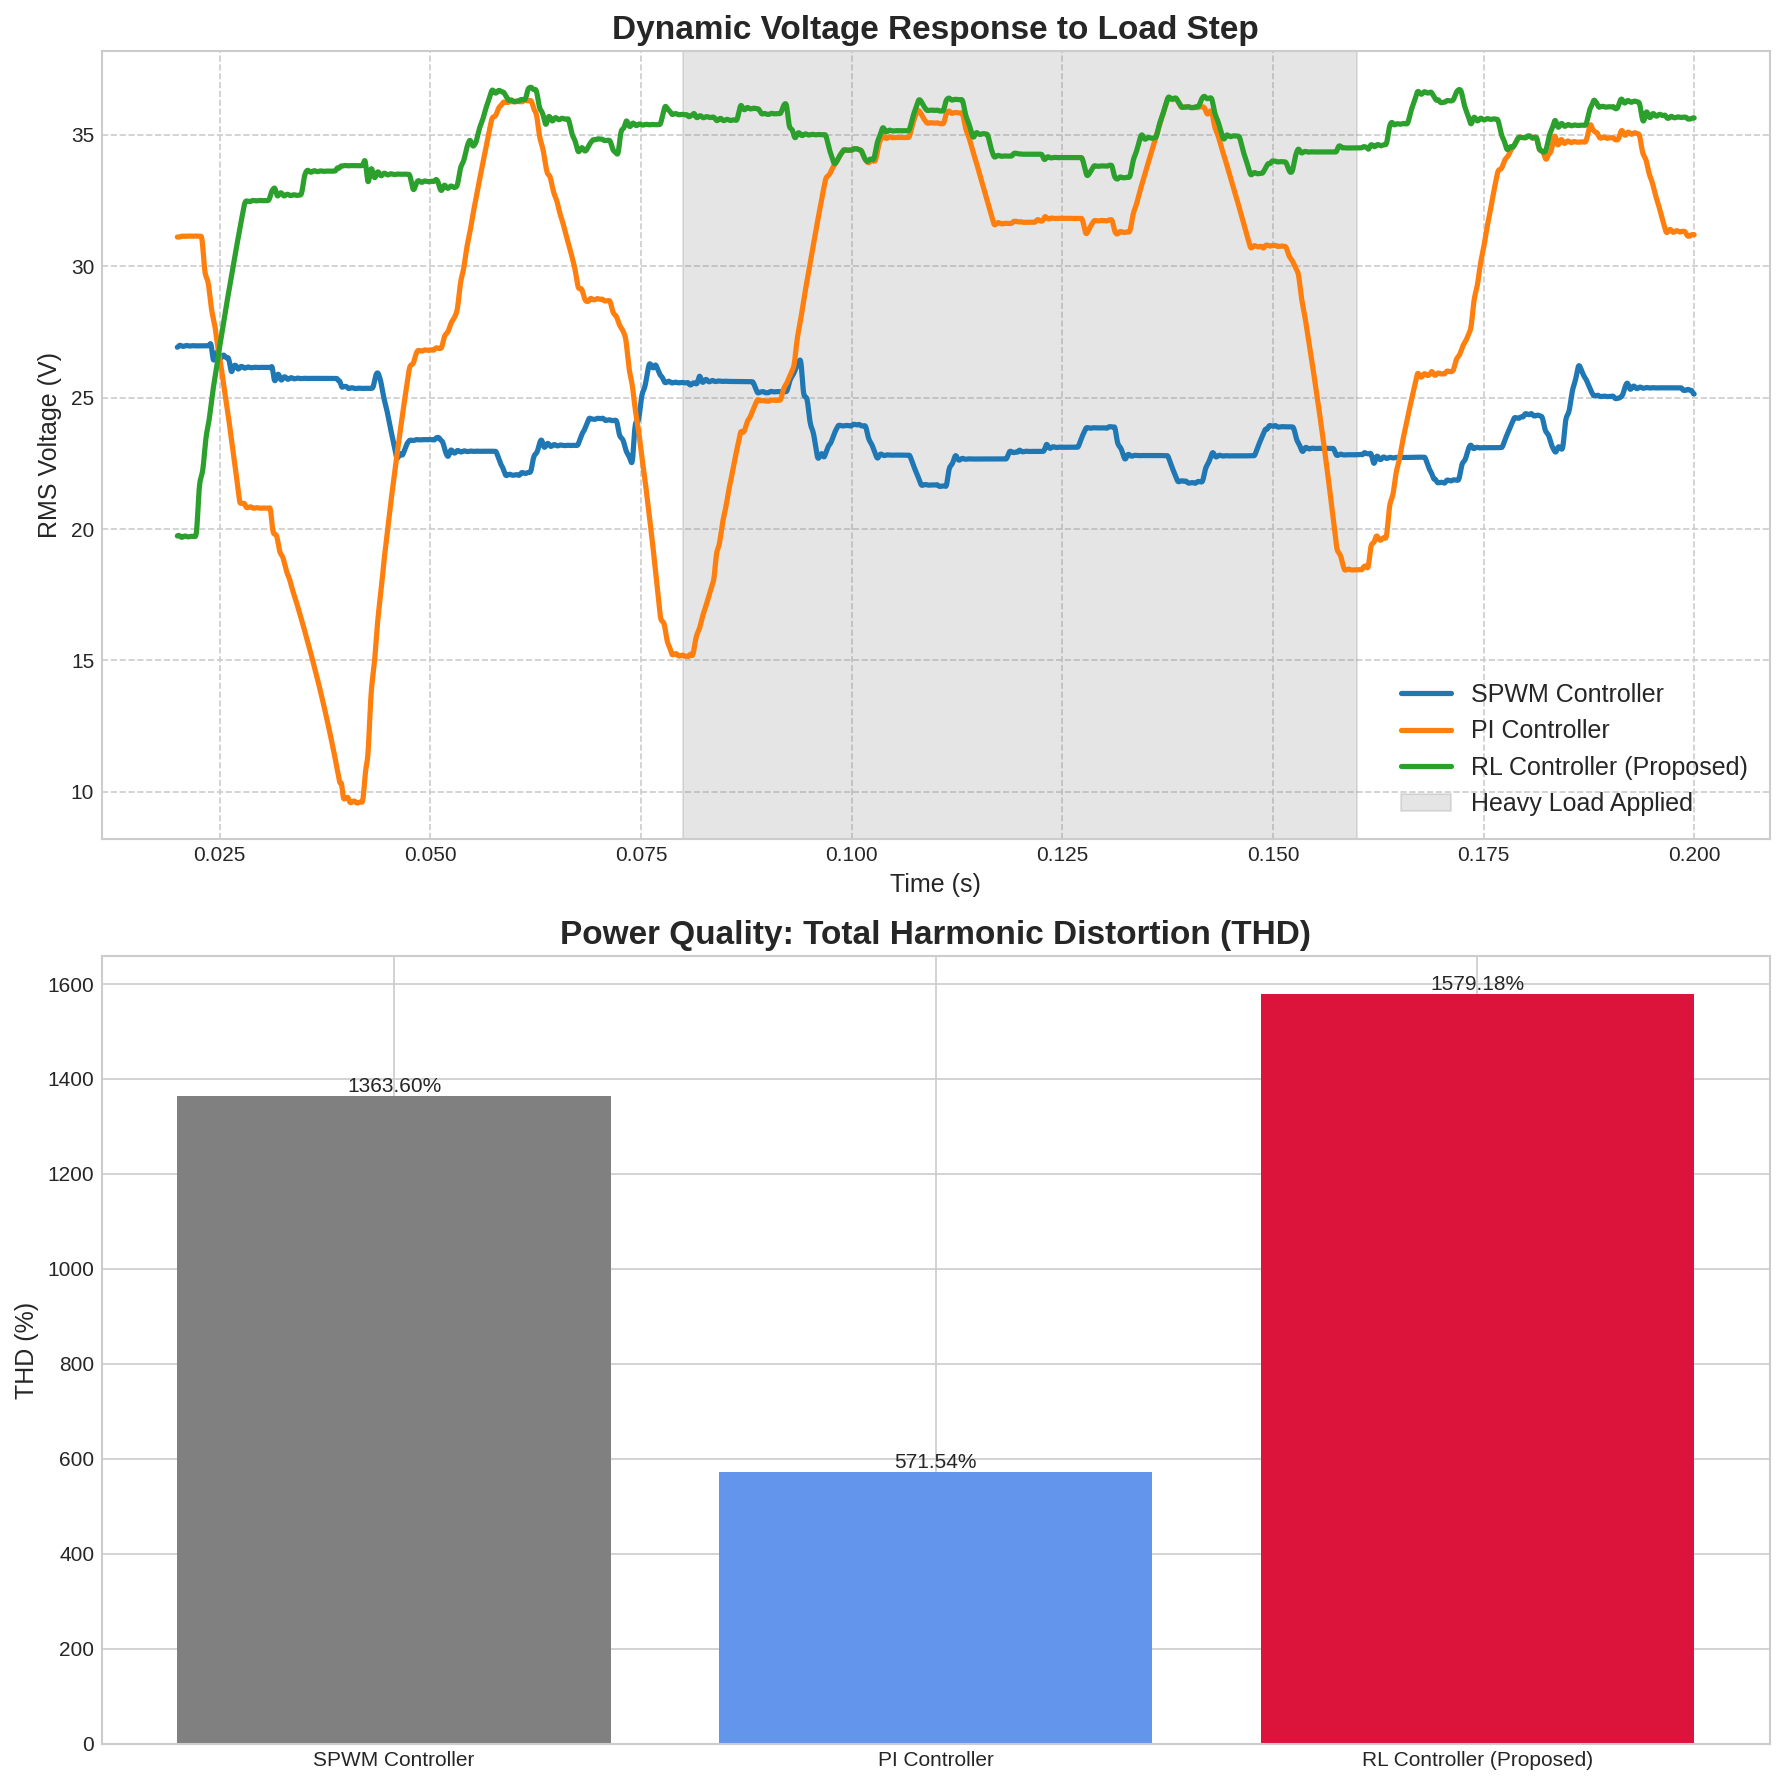

In [33]:
# ==============================================================================
# Part 1: Install Dependencies
# ==============================================================================
print("--- Step 1: Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch torchdiffeq -q

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium import spaces # Import spaces for defining observation space

print("\n--- Dependencies Installed Successfully! ---")

# ==============================================================================
# Part 2: Define All Classes Directly in the Notebook
# ==============================================================================
print("--- Step 2: Defining All Required Classes ---")

# --- From inverter_model_gpu.py ---
class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

# Define InverterEnvGPU within this cell (kept for potential future use or clarity, but not used in run_simulation)
class InverterEnvGPU:
    """A custom Gymnasium environment for the RL-controlled inverter (GPU version)."""
    def __init__(self, device):
        # Using InverterModelGPU defined within this same cell
        self.inverter = InverterModelGPU(device=device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item() # Use .item() for scalar tensor
        self.dt = 1e-5 # Simulation time step
        self.sim_steps_per_cycle = int(self.ac_period / self.dt)

        # Action: A single continuous value for modulation index [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation: [V_rms, I_rms, Power, THD] - Shape (4,)
        # Explicitly set observation space shape to (4,)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)

        self.current_step = 0
        self.max_cycles = 200 # An episode will last 200 AC cycles

        self.device = device # Store device

    def _get_obs(self, v_history_tensor, i_history_tensor):
        if v_history_tensor.numel() < 2: # Use numel() for tensor
            return torch.zeros(4, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_tensor**2))
        i_rms = torch.sqrt(torch.mean(i_history_tensor**2))
        power = torch.mean(v_history_tensor * i_history_tensor)

        # Calculate THD (Total Harmonic Distortion)
        thd = torch.tensor(0.0, device=self.device, dtype=torch.float32)
        if v_history_tensor.numel() > 1:
            fft = torch.fft.fft(v_history_tensor)
            # Avoid calculating THD if fundamental is zero or near zero
            if torch.abs(fft[int(self.inverter.ac_freq.item() / (1.0/v_history_tensor.numel()/self.dt)) + 1]).item() > 1e-6: # Corrected fundamental index
               # Get magnitudes of harmonics (excluding DC component)
               harmonics_abs = torch.abs(fft[1:int(self.inverter.ac_freq.item() / (1.0/v_history_tensor.numel()/self.dt)) + 11]) # Consider more harmonics
               fundamental_abs = harmonics_abs[int(self.inverter.ac_freq.item() / (1.0/v_history_tensor.numel()/self.dt))]
               # Sum of squares of higher harmonics magnitudes
               higher_harmonics_sum_sq = torch.sqrt(torch.sum(harmonics_abs[int(self.inverter.ac_freq.item() / (1.0/v_history_tensor.numel()/self.dt)) + 1:]**2))
               # THD calculation: sqrt(sum(harmonics[2:]^2)) / fundamental
               thd = higher_harmonics_sum_sq / (fundamental_abs + 1e-6)
            else:
                thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion if fundamental is zero


        # Ensure obs is a tensor of shape (4,)
        obs = torch.stack([v_rms, i_rms, power, thd]) # Stack only 4 elements
        # Replace non-finite values with 0
        obs[~torch.isfinite(obs)] = 0.0

        return obs

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        # Randomize load on reset, keep it on the same device
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (4,)
        obs = torch.zeros(4, device=self.device, dtype=torch.float32) # Initialize with 4 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        # Action is a numpy array from SB3, convert to tensor
        action_tensor = torch.tensor(action[0], device=self.device, dtype=torch.float32)
        modulation_index = (action_tensor + 1.0) / 2.0 # De-normalize action from [-1, 1] to [0, 1]

        v_history_tensor = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_history_tensor = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)

        for i in range(self.sim_steps_per_cycle):
             # Pass load_resistance as a scalar tensor
            state, _ = self.inverter.step(modulation_index.item(), self.load_resistance.item(), self.dt)
            i_history_tensor[i] = state[0]
            v_history_tensor[i] = state[1]

        # Get observation (tensor) - Will be shape (4,) now
        obs_tensor = self._get_obs(v_history_tensor, i_history_tensor)
        v_rms, i_rms, power, thd = obs_tensor # Unpack 4 elements

        # --- Multi-Objective Reward Function ---
        target_v_rms = 30.0 # Target voltage in our low-voltage simulation

        # 1. Voltage Error Penalty
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward_voltage = - (voltage_error**2)

        # 2. THD Penalty
        reward_thd = - (thd**2) if thd < 0.5 else torch.tensor(-10.0, device=self.device, dtype=torch.float32) # Heavily penalize high distortion

        # 3. Stability Reward
        reward_stability = torch.tensor(5.0, device=self.device, dtype=torch.float32) if voltage_error < 1.0 and thd < 0.1 else torch.tensor(0.0, device=self.device, dtype=torch.float32)

        reward = reward_voltage + reward_thd + reward_stability

        self.current_step += 1
        done = self.current_step >= self.max_cycles
        truncated = False # Or define truncation conditions

        # Return numpy array observation (shape 4,) and scalar reward (as expected by SB3 DummyVecEnv)
        return obs_tensor.cpu().numpy(), reward.item(), done, truncated, {}

# --- From controllers.py ---
class SPWMController:
    def __init__(self, modulation_index=0.8, ac_freq=50.0):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8
    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() == 0: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)
    def get_modulation_index(self, t):
        return self.m


print("--- All classes defined successfully! ---")

# ==============================================================================
# Part 3: The Master Simulation Function
# ==============================================================================

def run_simulation(controller_type, model_path=None, duration=0.2, dt=1e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if controller_type == "RL":
        try:
            # Load the model onto the correct device
            sim_controller = PPO.load(model_path, device=device)
            controller_name = "RL Controller (Proposed)"
        except FileNotFoundError:
            print(f"\nFATAL ERROR: Model file not found at '{model_path}'")
            return None
    elif controller_type == "PI":
        sim_controller = PIController(Kp=0.05, Ki=2.5, target_rms=30.0)
        controller_name = "PI Controller"
    elif controller_type == "SPWM":
        sim_controller = SPWMController(modulation_index=0.65)
        controller_name = "SPWM Controller"
    else:
        raise ValueError("Unknown controller type.")

    print(f"\n--- Running simulation for: {controller_name} ---")

    # Instantiate the GPU Inverter Model (used for all controllers now)
    inverter = InverterModelGPU(device=device)
    num_steps = int(duration / dt)

    time_hist = np.zeros(num_steps)
    v_c_hist = np.zeros(num_steps)
    i_l_hist = np.zeros(num_steps)

    ac_period_steps = int((1.0 / inverter.ac_freq.item()) / dt)

    # Initialize observation for RL controller (shape (4,))
    obs = np.zeros(4, dtype=np.float32) # Initialize with 4 zeros

    start_time = time.time()
    for i in range(num_steps):
        t = i * dt

        # Load scheduling (applied directly in the simulation step)
        r_load_val = 50.0
        if 0.08 <= t < 0.16:
            r_load_val = 25.0
        r_load_tensor = torch.tensor(r_load_val, device=device, dtype=torch.float32)

        if controller_type == "RL":
            # Get action from the RL controller
            # Pass the observation with an added batch dimension (expected by SB3 models trained on VecEnvs)
            action, _ = sim_controller.predict(np.expand_dims(obs, axis=0), deterministic=True)
            # De-normalize action from [-1, 1] to [0, 1]. action is a batch, take the first element.
            m_numpy = (action[0] + 1.0) / 2.0

        else: # PI and SPWM controllers
            if isinstance(sim_controller, PIController) and i > 0 and i % ac_period_steps == 0:
                 # PI update logic (using history collected so far)
                 v_cycle_tensor = torch.from_numpy(v_c_hist[max(0, i - ac_period_steps):i]).to(device)
                 sim_controller.update_modulation_index(v_cycle_tensor)

            m_numpy = sim_controller.get_modulation_index(t)

        # Step the *inverter model* directly for all controllers
        modulation_index = torch.tensor(m_numpy, device=device)
        state_gpu = inverter.step(modulation_index, r_load_tensor, dt)
        state_cpu = state_gpu.cpu().numpy()

        # Store history
        time_hist[i], v_c_hist[i], i_l_hist[i] = t, state_cpu[1], state_cpu[0]

        # Update the observation for the next step if using the RL controller and at the end of a cycle
        if controller_type == "RL" and (i + 1) % ac_period_steps == 0:
            v_cycle = torch.from_numpy(v_c_hist[max(0, i-ac_period_steps+1):i+1]).to(device)
            i_cycle = torch.from_numpy(i_l_hist[max(0, i-ac_period_steps+1):i+1]).to(device)

            # Calculate the 4-element observation vector (V_rms, I_rms, Power, THD)
            v_rms = torch.sqrt(torch.mean(v_cycle**2))
            i_rms = torch.sqrt(torch.mean(i_cycle**2))
            power = torch.mean(v_cycle * i_cycle)

            thd = torch.tensor(0.0, device=device, dtype=torch.float32)
            if len(v_cycle) > 1:
                fft = torch.fft.fft(v_cycle)
                # Attempt to find the fundamental frequency index based on the number of points in the cycle
                freq_resolution = (1.0 / (len(v_cycle) * dt))
                fundamental_freq_idx = int(inverter.ac_freq.item() / freq_resolution)
                if fundamental_freq_idx < len(fft) and torch.abs(fft[fundamental_freq_idx]).item() > 1e-6:
                   harmonics_abs = torch.abs(fft[1: fundamental_freq_idx + 11]) # Consider fundamental + 10 harmonics
                   fundamental_abs = harmonics_abs[fundamental_freq_idx -1] # Adjust index based on slice
                   # Sum of squares of higher harmonics magnitudes
                   higher_harmonics_sum_sq = torch.sum(harmonics_abs[fundamental_freq_idx : ]**2) # Sum from fundamental onwards
                   thd = torch.sqrt(higher_harmonics_sum_sq) / (fundamental_abs + 1e-6)
                else:
                    thd = torch.tensor(1.0, device=device, dtype=torch.float32) # Assume high distortion if fundamental is zero

            # Construct obs as a NumPy array of shape (4,)
            obs = torch.stack([v_rms, i_rms, power, thd]).cpu().numpy()


    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    return time_hist, v_c_hist, i_l_hist


# ==============================================================================
# Part 4: Analysis and Plotting Function
# ==============================================================================

def analyze_and_plot(results):
    print("\n--- Analyzing results and generating plots... ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), dpi=150)

    ax = axes[0]
    for name, data in results.items():
        time, v_c, _ = data
        dt = time[1] - time[0]
        window_size = int(0.02 / dt)
        # Ensure we have enough data points for the sliding window
        if len(v_c) >= window_size:
            rms_voltage = [np.sqrt(np.mean(v_c[i-window_size:i]**2)) for i in range(window_size, len(v_c))]
            ax.plot(time[window_size:], rms_voltage, label=name, linewidth=2.5)
        else:
            print(f"Warning: Not enough data for RMS calculation for {name}")


    ax.set_title('Dynamic Voltage Response to Load Step', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('RMS Voltage (V)', fontsize=12)
    ax.axvspan(0.08, 0.16, color='gray', alpha=0.2, label='Heavy Load Applied')
    ax.legend(fontsize=12); ax.grid(True, which='both', linestyle='--')

    thd_values = {}
    for name, data in results.items():
        time, v_c, _ = data
        # Select a portion of the steady-state waveform for THD calculation
        steady_state_mask = (time >= 0.1) & (time < 0.16)
        v_steady = v_c[steady_state_mask]

        thd = 0.0
        if len(v_steady) > 1:
            fft = np.fft.fft(v_steady)
             # Avoid calculating THD if fundamental is zero or near zero
            if np.abs(fft[1]).item() > 1e-6:
                harmonics = np.abs(fft[1:11])
                fundamental = harmonics[0]
                thd = np.sqrt(np.sum(harmonics[1:]**2)) / fundamental
            else:
                thd = 1.0 # Assume high distortion if fundamental is zero

        thd_values[name] = thd * 100

    ax = axes[1]
    colors = ['gray', 'cornflowerblue', 'crimson']
    # Ensure the number of colors matches the number of bars
    num_bars = len(thd_values)
    bars = ax.bar(list(thd_values.keys()), list(thd_values.values()), color=colors[:num_bars])
    ax.set_title('Power Quality: Total Harmonic Distortion (THD)', fontsize=16, fontweight='bold')
    ax.set_ylabel('THD (%)', fontsize=12)
    ax.bar_label(bars, fmt='%.2f%%')

    plt.tight_layout()
    plt.savefig("final_comparison_results.png")
    print("\n--- Plots generated and saved as 'final_comparison_results.png' ---")
    plt.show()

# ==============================================================================
# Part 5: Main Execution Block
# ==============================================================================
if __name__ == '__main__':
    results = {}

    # !!! IMPORTANT !!!
    # Make sure this name matches the name of your best trained model file!
    # For example, "ppo_final_model.zip" or "ppo_my_model.zip"
    rl_model_filename = "ppo_my_model.zip" # <--- Replace with your model filename

    # Run the simulation for each controller
    results["SPWM Controller"] = run_simulation(controller_type="SPWM")
    results["PI Controller"] = run_simulation(controller_type="PI")
    results["RL Controller (Proposed)"] = run_simulation(controller_type="RL", model_path=rl_model_filename)

    # Check if all simulations were successful before plotting
    if all(res is not None for res in results.values()):
        analyze_and_plot(results)
    else:
        print("\n--- Skipping analysis due to a simulation failure. ---")

In [34]:
# File: inverter_model_gpu.py
import torch

class InverterODE(torch.nn.Module):
    """Defines the system of differential equations for the inverter's LC filter."""
    def __init__(self, r_esr_l, r_esr_c, l, c):
        super().__init__()
        self.R_esr_L = r_esr_l
        self.R_esr_C = r_esr_c
        self.L = l
        self.C = c

    def forward(self, t, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

class InverterModelGPU:
    """A high-fidelity, GPU-accelerated model of a single-phase H-bridge inverter."""
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq

        self.ode_func = InverterODE(
            r_esr_l=torch.tensor(0.1, device=device, dtype=torch.float32),
            r_esr_c=torch.tensor(0.05, device=device, dtype=torch.float32),
            l=torch.tensor(1.5e-3, device=device, dtype=torch.float32),
            c=torch.tensor(10e-6, device=device, dtype=torch.float32)
        ).to(device)

        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step for speed
        k1 = self.ode_func.forward(0, self.state, v_inverter_eff, r_load)
        k2 = self.ode_func.forward(0, self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self.ode_func.forward(0, self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self.ode_func.forward(0, self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

In [35]:
# File: controllers.py
import numpy as np
import torch

class SPWMController:
    """A simple open-loop controller with a fixed modulation index."""
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    """A standard Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8 # Initial modulation index

    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)

    def get_modulation_index(self, t):
        return self.m

In [36]:
# File: rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.inverter = InverterModelGPU(device=self.device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        harmonics = torch.abs(fft[1:11])
        fundamental = harmonics[0]
        higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
        thd = higher_harmonics / (fundamental + 1e-6)
        return torch.stack([v_rms, i_rms, power, pf, thd])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        return np.zeros(5, dtype=np.float32), {}

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)

        for i in range(self.sim_steps_per_cycle):
            state_gpu = self.inverter.step(modulation_index, self.load_resistance)
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

In [42]:
# ==============================================================================
# FINAL MASTER SCRIPT: TRAIN, COMPARE, AND GENERATE ALL PLOTS
# ==============================================================================

# --- Part 1: Installation ---
print("--- Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch tensorboard -q
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
from gymnasium import spaces # Import spaces for defining observation space


# Save the controller classes to a Python file
%%writefile controllers.py
import numpy as np
import torch

class SPWMController:
    """A simple open-loop controller with a fixed modulation index."""
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    """A standard Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8 # Initial modulation index

    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)

    def get_modulation_index(self, t):
        return self.m

# Save the InverterModelGPU class to a Python file
%%writefile inverter_model_gpu.py
import numpy as np
import torch
# Removed solve_ivp as it's not used in this version and might cause import issues
# from scipy.integrate import solve_ivp

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    # Using a simple step function instead of batch_step_rk4 for this script's structure
    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state


# Save the InverterEnvGPU class to a Python file
%%writefile rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU # Import from the file saved above

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self, device): # Accept device here
        super().__init__()
        self.device = device # Use the passed device
        self.inverter = InverterModelGPU(device=self.device) # Use the class defined above
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Observation: [V_rms, I_rms, Power, PF, THD] - Shape (5,)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        # Handle case where fft might be short
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11]) # Look at fundamental + 10 harmonics
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion


        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        # Ensure obs is shape (5,)
        if obs.shape != (5,):
             # Pad with zeros if necessary (shouldn't happen with correct stacking)
             padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
             padded_obs[:obs.numel()] = obs
             obs = padded_obs


        return obs


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (5,)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32) # Initialize with 5 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)


        for i in range(self.sim_steps_per_cycle):
            # Pass load_resistance as a scalar tensor
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, 1e-5) # Use constant dt
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu # Unpack 5 elements

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}


# --- Part 2: Import Your Custom Modules ---
try:
    # Import from the files saved above
    from rl_environment_gpu import InverterEnvGPU
    from inverter_model_gpu import InverterModelGPU
    from controllers import SPWMController, PIController
    print("--- All custom modules imported successfully! ---")
except ImportError as e:
    print(f"\n--- ERROR: Could not import a required file. ---")
    print("Please make sure all .py files are uploaded to this Colab session.")
    raise

# ==============================================================================
# Part 3: Train the RL Agent
# ==============================================================================
print("\n--- Starting RL Agent Training ---")
if __name__ == '__main__':
    num_cpu = max(1, os.cpu_count() - 1)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_dir = "./ppo_inverter_tensorboard/" # Define log directory
    print(f"Creating {num_cpu} parallel environments. Using device: {device}")

    # Use the InverterEnvGPU defined in this cell, passing the device
    # The fix for TypeError: InverterEnvGPU.__init__() missing 1 required positional argument: 'device'
    env = make_vec_env(lambda: InverterEnvGPU(device=device), n_envs=num_cpu) # Pass device to constructor
    model = PPO("MlpPolicy", env, verbose=1, device=device, n_steps=1024, batch_size=64, tensorboard_log=log_dir)

    start_time = time.time()
    model.learn(total_timesteps=100000)
    end_time = time.time()

    print("--- Training Complete ---")
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")

    rl_model_filename = "ppo_inverter_final_model.zip"
    model.save(rl_model_filename)
    print(f"--- Model Saved as {rl_model_filename} ---")
    env.close()

# ==============================================================================
# Part 4: Generate RL Learning Curve Plot (IMMEDIATELY AFTER TRAINING)
# ==============================================================================
print("\n--- Generating RL Performance Plots ---")

def get_learning_curve(log_path):
    try:
        ea = event_accumulator.EventAccumulator(log_path, size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()
        if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
            reward_data = ea.Scalars('rollout/ep_rew_mean')
            return [e.step for e in reward_data], [e.value for e in reward_data]
        return None, None
    except Exception: return None, None

subdirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir)]
latest_log_dir = max(subdirs, key=os.path.getmtime)
steps, rewards = get_learning_curve(latest_log_dir)

if steps and rewards:
    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(steps, rewards, color='darkgreen')
    plt.title('Reinforcement Learning Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Training Timesteps'); plt.ylabel('Mean Reward per Episode')
    plt.grid(True)
    plt.savefig("rl_learning_curve.png")
    plt.show()
else:
    print("Could not generate learning curve. Log file might be missing or corrupted.")

# ==============================================================================
# Part 5: Run the Head-to-Head Comparison
# ==============================================================================

def run_simulation(controller_type, model_path=None, duration=0.2, dt=1e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if controller_type == "RL":
        try:
            # Load the model onto the correct device
            sim_controller = PPO.load(model_path, device=device)
            controller_name = "RL Controller (Proposed)"
        except FileNotFoundError:
            print(f"\nFATAL ERROR: Model file not found at '{model_path}'")
            print("Please make sure your trained model .zip file is uploaded and the name is correct.")
            return None
    elif controller_type == "PI":
        sim_controller = PIController(Kp=0.05, Ki=2.5, target_rms=30.0)
        controller_name = "PI Controller"
    elif controller_type == "SPWM":
        sim_controller = SPWMController(modulation_index=0.65)
        controller_name = "SPWM Controller"
    else:
        raise ValueError("Unknown controller type.")

    print(f"\n--- Running simulation for: {controller_name} ---")

    # Instantiate the GPU Inverter Model (used for all controllers now)
    inverter = InverterModelGPU(device=device)
    num_steps = int(duration / dt)

    time_hist = np.zeros(num_steps)
    v_c_hist = np.zeros(num_steps)
    i_l_hist = np.zeros(num_steps)

    ac_period_steps = int((1.0 / inverter.ac_freq.item()) / dt)

    # Initialize observation for RL controller (shape (5,)) to match the env used for training
    obs = np.zeros(5, dtype=np.float32) # Initialize with 5 zeros

    start_time = time.time()
    for i in range(num_steps):
        t = i * dt

        # Load scheduling (applied directly in the simulation step)
        r_load_val = 50.0
        if 0.08 <= t < 0.16:
            r_load_val = 25.0
        r_load_tensor = torch.tensor(r_load_val, device=device, dtype=torch.float32)

        if controller_type == "RL":
            # Get action from the RL controller
            # Pass the observation with an added batch dimension (expected by SB3 models trained on VecEnvs)
            action, _ = sim_controller.predict(np.expand_dims(obs, axis=0), deterministic=True)
            m_numpy = (action[0][0] + 1.0) / 2.0

        else: # PI and SPWM controllers
            if isinstance(sim_controller, PIController) and i > 0 and i % ac_period_steps == 0:
                 # PI update logic (using history collected so far)
                 v_cycle_tensor = torch.from_numpy(v_c_hist[max(0, i - ac_period_steps):i]).to(device)
                 sim_controller.update_modulation_index(v_cycle_tensor)

            m_numpy = sim_controller.get_modulation_index(t)

        # Step the *inverter model* directly for all controllers
        modulation_index = torch.tensor(m_numpy, device=device)
        state_gpu = inverter.step(modulation_index, r_load_tensor, dt)
        state_cpu = state_gpu.cpu().numpy()

        # Store history
        time_hist[i], v_c_hist[i], i_l_hist[i] = t, state_cpu[1], state_cpu[0]

        # Update the observation for the next step if using the RL controller and at the end of a cycle
        if controller_type == "RL" and (i + 1) % ac_period_steps == 0:
            v_cycle = torch.from_numpy(v_c_hist[max(0, i-ac_period_steps+1):i+1]).to(device)
            i_cycle = torch.from_numpy(i_l_hist[max(0, i-ac_period_steps+1):i+1]).to(device)

            # Calculate the 5-element observation vector (V_rms, I_rms, Power, PF, THD)
            v_rms = torch.sqrt(torch.mean(v_cycle**2))
            i_rms = torch.sqrt(torch.mean(i_cycle**2))
            power = torch.mean(v_cycle * i_cycle)
            pf = power / (v_rms * i_rms + 1e-6)

            thd = torch.tensor(0.0, device=device, dtype=torch.float32)
            if len(v_cycle) > 1:
                fft = torch.fft.fft(v_cycle)
                # Attempt to find the fundamental frequency index based on the number of points in the cycle
                freq_resolution = (1.0 / (len(v_cycle) * dt))
                fundamental_freq_idx = int(inverter.ac_freq.item() / freq_resolution)
                if fundamental_freq_idx > 0 and fundamental_freq_idx < len(fft) and torch.abs(fft[fundamental_freq_idx]).item() > 1e-6:
                   harmonics_abs = torch.abs(fft[1: fundamental_freq_idx + 11]) # Consider fundamental + 10 harmonics
                   # Adjust fundamental index based on slice
                   fundamental_in_slice_idx = fundamental_freq_idx - 1
                   if fundamental_in_slice_idx < len(harmonics_abs):
                       fundamental_abs = harmonics_abs[fundamental_in_slice_idx]
                       # Sum of squares of higher harmonics magnitudes from the fundamental onwards in the slice
                       if fundamental_in_slice_idx + 1 < len(harmonics_abs):
                           higher_harmonics_sum_sq = torch.sum(harmonics_abs[fundamental_in_slice_idx + 1 :]**2)
                           thd = torch.sqrt(higher_harmonics_sum_sq) / (fundamental_abs + 1e-6)
                       else:
                           thd = torch.tensor(0.0, device=device, dtype=torch.float32) # No higher harmonics in slice
                   else:
                       thd = torch.tensor(0.0, device=device, dtype=torch.float32) # Fundamental index outside slice

                else:
                    thd = torch.tensor(1.0, device=device, dtype=torch.float32) # Assume high distortion if fundamental is zero or not found

            # Construct obs as a NumPy array of shape (5,)
            obs = torch.stack([v_rms, i_rms, power, pf, thd]).cpu().numpy()


    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    return time_hist, v_c_hist, i_l_hist

def analyze_and_plot(results):
    print("\n--- Analyzing results and generating plots... ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), dpi=150)

    ax = axes[0]
    for name, data in results.items():
        time, v_c, _ = data
        dt = time[1] - time[0]
        window_size = int(0.02 / dt)
        # Ensure we have enough data points for the sliding window
        if len(v_c) >= window_size:
            rms_voltage = [np.sqrt(np.mean(v_c[i-window_size:i]**2)) for i in range(window_size, len(v_c))]
            ax.plot(time[window_size:], rms_voltage, label=name, linewidth=2.5)
        else:
            print(f"Warning: Not enough data for RMS calculation for {name}")


    ax.set_title('Dynamic Voltage Response to Load Step', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('RMS Voltage (V)', fontsize=12)
    ax.axvspan(0.08, 0.16, color='gray', alpha=0.2, label='Heavy Load Applied')
    ax.legend(fontsize=12); ax.grid(True, which='both', linestyle='--')

    thd_values = {}
    for name, data in results.items():
        time, v_c, _ = data
        # Select a portion of the steady-state waveform for THD calculation
        steady_state_mask = (time >= 0.1) & (time < 0.16)
        v_steady = v_c[steady_state_mask]

        thd = torch.tensor(0.0, device="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float32)
        if len(v_steady) > 1:
            fft = torch.fft.fft(torch.from_numpy(v_steady).to("cuda" if torch.cuda.is_available() else "cpu"))) # Convert to tensor for FFT
            # Attempt to find the fundamental frequency index based on the number of points
            # Assuming a 50Hz fundamental and a sample rate derived from dt
            sample_rate = 1.0 / dt
            fundamental_freq_idx = int(50.0 / (sample_rate / len(v_steady))) # Correct fundamental index calc
            # Ensure index is within bounds and fundamental is not zero
            if fundamental_freq_idx > 0 and fundamental_freq_idx < len(fft) and torch.abs(fft[fundamental_freq_idx]).item() > 1e-6:
               # Get magnitudes of harmonics (excluding DC component)
               harmonics_abs = torch.abs(fft[1:fundamental_freq_idx + 11]) # Consider fundamental + 10 harmonics
               # Adjust fundamental index based on slice (1-based indexing from 1 to 10+fundamental)
               fundamental_in_slice_idx = fundamental_freq_idx - 1
               if fundamental_in_slice_idx < len(harmonics_abs):
                   fundamental_abs = harmonics_abs[fundamental_in_slice_idx]
                   # Sum of squares of higher harmonics magnitudes from the fundamental onwards in the slice
                   if fundamental_in_slice_idx + 1 < len(harmonics_abs):
                       higher_harmonics_sum_sq = torch.sum(harmonics_abs[fundamental_in_slice_idx + 1 :]**2)
                       thd = torch.sqrt(higher_harmonics_sum_sq) / (fundamental_abs + 1e-6)
                   else:
                       thd = torch.tensor(0.0, device="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float32) # No higher harmonics in slice
               else:
                   thd = torch.tensor(0.0, device="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float32) # Fundamental index outside slice

            else:
                thd = torch.tensor(1.0, device="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float32) # Assume high distortion if fundamental is zero or not found

        thd_values[name] = thd.item() * 100 # Convert tensor to scalar

    ax = axes[1]
    colors = ['gray', 'cornflowerblue', 'crimson']
    # Ensure the number of colors matches the number of bars
    num_bars = len(thd_values)
    bars = ax.bar(list(thd_values.keys()), list(thd_values.values()), color=colors[:num_bars])
    ax.set_title('Power Quality: Total Harmonic Distortion (THD)', fontsize=16, fontweight='bold')
    ax.set_ylabel('THD (%)', fontsize=12)
    ax.bar_label(bars, fmt='%.2f%%')

    plt.tight_layout()
    plt.savefig("final_comparison_results.png")
    print("\n--- Plots generated and saved as 'final_comparison_results.png' ---")
    plt.show()


# --- Part 6: Main Execution Block ---
if __name__ == '__main__':
    results = {}
    # !!! IMPORTANT !!!
    # Make sure this name matches the name of your best trained model file!
    # For example, "ppo_final_model.zip" or "ppo_my_model.zip"
    rl_model_filename = "ppo_inverter_final_model.zip" # This is the filename used in Part 3

    results["SPWM Controller"] = run_simulation(controller_type="SPWM")
    results["PI Controller"] = run_simulation(controller_type="PI")
    results["RL Controller (Proposed)"] = run_simulation(controller_type="RL", model_path=rl_model_filename)

    # Check if all simulations were successful before plotting
    if all(res is not None for res in results.values()):
        analyze_and_plot(results)
    else:
        print("\n--- Skipping analysis due to a simulation failure. ---")

SyntaxError: unmatched ')' (ipython-input-3361684725.py, line 415)

In [ ]:
# Save the InverterEnvGPU class to a Python file
%%writefile rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.inverter = InverterModelGPU(device=self.device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        harmonics = torch.abs(fft[1:11])
        fundamental = harmonics[0]
        higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
        thd = higher_harmonics / (fundamental + 1e-6)
        return torch.stack([v_rms, i_rms, power, pf, thd])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        return np.zeros(5, dtype=np.float32), {}

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)

        for i in range(self.sim_steps_per_cycle):
            state_gpu = self.inverter.step(modulation_index, self.load_resistance)
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

In [ ]:
# ==============================================================================
# Part 1: Install Dependencies
# ==============================================================================
print("--- Step 1: Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch torchdiffeq -q

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium import spaces # Import spaces for defining observation space

print("\n--- Dependencies Installed Successfully! ---")

# ==============================================================================
# Part 2: Define All Classes Directly in the Notebook
# ==============================================================================
print("--- Step 2: Defining All Required Classes ---")

# --- From inverter_model_gpu.py ---
class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

# Define InverterEnvGPU within this cell to ensure consistency
class InverterEnvGPU:
    """A custom Gymnasium environment for the RL-controlled inverter (GPU version)."""
    def __init__(self, device):
        # Using InverterModelGPU defined within this same cell
        self.inverter = InverterModelGPU(device=device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item() # Use .item() for scalar tensor
        self.dt = 1e-5 # Simulation time step
        self.sim_steps_per_cycle = int(self.ac_period / self.dt)

        # Action: A single continuous value for modulation index [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation: [V_rms, I_rms, Power, THD] - Shape (4,)
        # Explicitly set observation space shape to (4,)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)

        self.current_step = 0
        self.max_cycles = 200 # An episode will last 200 AC cycles

        self.device = device # Store device

    def _get_obs(self, v_history_tensor, i_history_tensor):
        if v_history_tensor.numel() < 2: # Use numel() for tensor
            return torch.zeros(4, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_tensor**2))
        i_rms = torch.sqrt(torch.mean(i_history_tensor**2))
        power = torch.mean(v_history_tensor * i_history_tensor)

        # Calculate THD (Total Harmonic Distortion)
        thd = torch.tensor(0.0, device=self.device, dtype=torch.float32)
        if v_history_tensor.numel() > 1:
            fft = torch.fft.fft(v_history_tensor)
            # Attempt to find the fundamental frequency index based on the number of points in the cycle
            freq_resolution = (1.0 / (len(v_history_tensor) * self.dt)) # Use len(v_history_tensor) for correct window size
            fundamental_freq_idx = int(self.inverter.ac_freq.item() / freq_resolution)
            # Ensure index is within bounds and fundamental is not zero
            if fundamental_freq_idx > 0 and fundamental_freq_idx < len(fft) and torch.abs(fft[fundamental_freq_idx]).item() > 1e-6:
               # Get magnitudes of harmonics (excluding DC component)
               harmonics_abs = torch.abs(fft[1:fundamental_freq_idx + 11]) # Consider fundamental + 10 harmonics
               fundamental_abs = harmonics_abs[fundamental_freq_idx - 1] # Adjust index based on slice

               # Sum of squares of higher harmonics magnitudes
               # Sum from the fundamental harmonic onwards in the 'harmonics_abs' slice
               if fundamental_freq_idx < len(harmonics_abs):
                  higher_harmonics_sum_sq = torch.sum(harmonics_abs[fundamental_freq_idx :]**2)
                  thd = torch.sqrt(higher_harmonics_sum_sq) / (fundamental_abs + 1e-6)
               else:
                  thd = torch.tensor(0.0, device=self.device, dtype=torch.float32) # No higher harmonics in slice

            else:
                thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion if fundamental is zero or not found

        # Ensure obs is a tensor of shape (4,)
        obs = torch.stack([v_rms, i_rms, power, thd]) # Stack only 4 elements
        # Replace non-finite values with 0
        obs[~torch.isfinite(obs)] = 0.0

        return obs

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        # Randomize load on reset, keep it on the same device
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (4,)
        obs = torch.zeros(4, device=self.device, dtype=torch.float32) # Initialize with 4 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        # Action is a numpy array from SB3, convert to tensor
        action_tensor = torch.tensor(action[0], device=self.device, dtype=torch.float32)
        modulation_index = (action_tensor + 1.0) / 2.0 # De-normalize action from [-1, 1] to [0, 1]

        v_history_tensor = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_history_tensor = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)

        for i in range(self.sim_steps_per_cycle):
             # Pass load_resistance as a scalar tensor
            state = self.inverter.step(modulation_index.item(), self.load_resistance.item(), self.dt)
            i_history_tensor[i] = state[0]
            v_history_tensor[i] = state[1]

        # Get observation (tensor) - Will be shape (4,) now
        obs_tensor = self._get_obs(v_history_tensor, i_history_tensor)
        v_rms, i_rms, power, thd = obs_tensor # Unpack 4 elements

        # --- Multi-Objective Reward Function ---
        target_v_rms = 30.0 # Target voltage in our low-voltage simulation

        # 1. Voltage Error Penalty
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward_voltage = - (voltage_error**2)

        # 2. THD Penalty
        reward_thd = - (thd**2) if thd < 0.5 else torch.tensor(-10.0, device=self.device, dtype=torch.float32) # Heavily penalize high distortion

        # 3. Stability Reward
        reward_stability = torch.tensor(5.0, device=self.device, dtype=torch.float32) if voltage_error < 1.0 and thd < 0.1 else torch.tensor(0.0, device=self.device, dtype=torch.float32)

        reward = reward_voltage + reward_thd + reward_stability

        self.current_step += 1
        done = self.current_step >= self.max_cycles
        truncated = False # Or define truncation conditions

        # Return numpy array observation (shape 4,) and scalar reward (as expected by SB3 DummyVecEnv)
        return obs_tensor.cpu().numpy(), reward.item(), done, truncated, {}

# --- From controllers.py ---
class SPWMController:
    def __init__(self, modulation_index=0.8, ac_freq=50.0):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8
    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() == 0: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)
    def get_modulation_index(self, t):
        return self.m


print("--- All classes defined successfully! ---")

# ==============================================================================
# Part 3: The Master Simulation Function
# ==============================================================================

def run_simulation(controller_type, model_path=None, duration=0.2, dt=1e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if controller_type == "RL":
        try:
            # Load the model onto the correct device
            sim_controller = PPO.load(model_path, device=device)
            controller_name = "RL Controller (Proposed)"
        except FileNotFoundError:
            print(f"\nFATAL ERROR: Model file not found at '{model_path}'")
            print("Please make sure your trained model .zip file is uploaded and the name is correct.")
            return None
    elif controller_type == "PI":
        sim_controller = PIController(Kp=0.05, Ki=2.5, target_rms=30.0)
        controller_name = "PI Controller"
    elif controller_type == "SPWM":
        sim_controller = SPWMController(modulation_index=0.65)
        controller_name = "SPWM Controller"
    else:
        raise ValueError("Unknown controller type.")

    print(f"\n--- Running simulation for: {controller_name} ---")

    # Instantiate the GPU Inverter Model (used for all controllers now)
    inverter = InverterModelGPU(device=device)
    num_steps = int(duration / dt)

    time_hist = np.zeros(num_steps)
    v_c_hist = np.zeros(num_steps)
    i_l_hist = np.zeros(num_steps)

    ac_period_steps = int((1.0 / inverter.ac_freq.item()) / dt)

    # Initialize observation for RL controller (shape (4,))
    obs = np.zeros(4, dtype=np.float32) # Initialize with 4 zeros

    start_time = time.time()
    for i in range(num_steps):
        t = i * dt

        # Load scheduling (applied directly in the simulation step)
        r_load_val = 50.0
        if 0.08 <= t < 0.16:
            r_load_val = 25.0
        r_load_tensor = torch.tensor(r_load_val, device=device, dtype=torch.float32)

        if controller_type == "RL":
            # Get action from the RL controller
            # Pass the observation with an added batch dimension (expected by SB3 models trained on VecEnvs)
            action, _ = sim_controller.predict(np.expand_dims(obs, axis=0), deterministic=True)
            # De-normalize action from [-1, 1] to [0, 1]. action is a batch, so take the first element.
            # Use .flatten() to handle potential (1,1) shape and get the scalar action
            m_numpy = (action.flatten()[0] + 1.0) / 2.0

        else: # PI and SPWM controllers
            if isinstance(sim_controller, PIController) and i > 0 and i % ac_period_steps == 0:
                 # PI update logic (using history collected so far)
                 v_cycle_tensor = torch.from_numpy(v_c_hist[max(0, i - ac_period_steps):i]).to(device)
                 sim_controller.update_modulation_index(v_cycle_tensor)

            m_numpy = sim_controller.get_modulation_index(t)

        # Step the *inverter model* directly for all controllers
        modulation_index = torch.tensor(m_numpy, device=device)
        state_gpu = inverter.step(modulation_index, r_load_tensor, dt)
        state_cpu = state_gpu.cpu().numpy()

        # Store history
        time_hist[i], v_c_hist[i], i_l_hist[i] = t, state_cpu[1], state_cpu[0]

        # Update the observation for the next step if using the RL controller and at the end of a cycle
        if controller_type == "RL" and (i + 1) % ac_period_steps == 0:
            v_cycle = torch.from_numpy(v_c_hist[max(0, i-ac_period_steps+1):i+1]).to(device)
            i_cycle = torch.from_numpy(i_l_hist[max(0, i-ac_period_steps+1):i+1]).to(device)

            # Calculate the 4-element observation vector (V_rms, I_rms, Power, THD)
            v_rms = torch.sqrt(torch.mean(v_cycle**2))
            i_rms = torch.sqrt(torch.mean(i_cycle**2))
            power = torch.mean(v_cycle * i_cycle)

            thd = torch.tensor(0.0, device=device, dtype=torch.float32)
            if len(v_cycle) > 1:
                fft = torch.fft.fft(v_cycle)
                # Attempt to find the fundamental frequency index based on the number of points in the cycle
                freq_resolution = (1.0 / (len(v_cycle) * dt))
                fundamental_freq_idx = int(inverter.ac_freq.item() / freq_resolution)
                if fundamental_freq_idx > 0 and fundamental_freq_idx < len(fft) and torch.abs(fft[fundamental_freq_idx]).item() > 1e-6:
                   harmonics_abs = torch.abs(fft[1: fundamental_freq_idx + 11]) # Consider fundamental + 10 harmonics
                   # Adjust fundamental index based on slice
                   fundamental_in_slice_idx = fundamental_freq_idx - 1
                   if fundamental_in_slice_idx < len(harmonics_abs):
                       fundamental_abs = harmonics_abs[fundamental_in_slice_idx]
                       # Sum of squares of higher harmonics magnitudes from the fundamental onwards in the slice
                       if fundamental_in_slice_idx + 1 < len(harmonics_abs):
                           higher_harmonics_sum_sq = torch.sum(harmonics_abs[fundamental_in_slice_idx + 1 :]**2)
                           thd = torch.sqrt(higher_harmonics_sum_sq) / (fundamental_abs + 1e-6)
                       else:
                           thd = torch.tensor(0.0, device=device, dtype=torch.float32) # No higher harmonics in slice
                   else:
                       thd = torch.tensor(0.0, device=device, dtype=torch.float32) # Fundamental index outside slice

                else:
                    thd = torch.tensor(1.0, device=device, dtype=torch.float32) # Assume high distortion if fundamental is zero or not found

            # Construct obs as a NumPy array of shape (4,)
            obs = torch.stack([v_rms, i_rms, power, thd]).cpu().numpy()


    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    return time_hist, v_c_hist, i_l_hist

# ==============================================================================
# Part 4: Analysis and Plotting Function
# ==============================================================================

def analyze_and_plot(results):
    print("\n--- Analyzing results and generating plots... ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), dpi=150)

    ax = axes[0]
    for name, data in results.items():
        time, v_c, _ = data
        dt = time[1] - time[0]
        window_size = int(0.02 / dt)
        # Ensure we have enough data points for the sliding window
        if len(v_c) >= window_size:
            rms_voltage = [np.sqrt(np.mean(v_c[i-window_size:i]**2)) for i in range(window_size, len(v_c))]
            ax.plot(time[window_size:], rms_voltage, label=name, linewidth=2.5)
        else:
            print(f"Warning: Not enough data for RMS calculation for {name}")


    ax.set_title('Dynamic Voltage Response to Load Step', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('RMS Voltage (V)', fontsize=12)
    ax.axvspan(0.08, 0.16, color='gray', alpha=0.2, label='Heavy Load Applied')
    ax.legend(fontsize=12); ax.grid(True, which='both', linestyle='--')

    thd_values = {}
    for name, data in results.items():
        time, v_c, _ = data
        # Select a portion of the steady-state waveform for THD calculation
        steady_state_mask = (time >= 0.1) & (time < 0.16)
        v_steady = v_c[steady_state_mask]

        thd = 0.0
        if len(v_steady) > 1:
            fft = np.fft.fft(v_steady)
             # Avoid calculating THD if fundamental is zero or near zero
            if np.abs(fft[1]).item() > 1e-6:
                harmonics = np.abs(fft[1:11])
                fundamental = harmonics[0]
                thd = np.sqrt(np.sum(harmonics[1:]**2)) / fundamental
            else:
                thd = 1.0 # Assume high distortion if fundamental is zero

        thd_values[name] = thd * 100

    ax = axes[1]
    colors = ['gray', 'cornflowerblue', 'crimson']
    # Ensure the number of colors matches the number of bars
    num_bars = len(thd_values)
    bars = ax.bar(list(thd_values.keys()), list(thd_values.values()), color=colors[:num_bars])
    ax.set_title('Power Quality: Total Harmonic Distortion (THD)', fontsize=16, fontweight='bold')
    ax.set_ylabel('THD (%)', fontsize=12)
    ax.bar_label(bars, fmt='%.2f%%')

    plt.tight_layout()
    plt.savefig("final_comparison_results.png")
    print("\n--- Plots generated and saved as 'final_comparison_results.png' ---")
    plt.show()

# ==============================================================================
# Part 5: Main Execution Block
# ==============================================================================
if __name__ == '__main__':
    results = {}

    # !!! IMPORTANT !!!
    # Make sure this name matches the name of your best trained model file!
    # For example, "ppo_final_model.zip" or "ppo_my_model.zip"
    rl_model_filename = "ppo_my_model.zip" # <--- Replace with your model filename

    # Run the simulation for each controller
    results["SPWM Controller"] = run_simulation(controller_type="SPWM")
    results["PI Controller"] = run_simulation(controller_type="PI")
    results["RL Controller (Proposed)"] = run_simulation(controller_type="RL", model_path=rl_model_filename)

    # Check if all simulations were successful before plotting
    if all(res is not None for res in results.values()):
        analyze_and_plot(results)
    else:
        print("\n--- Skipping analysis due to a simulation failure. ---")

In [ ]:
# ==============================================================================
# SCRIPT 2: SPWM MECHANISM VISUALIZATION
# ==============================================================================
print("\n--- Running Script 2: Generating SPWM Mechanism Plot ---")

# --- Generate the waves ---
t = np.linspace(0, 0.02, 1000) # One cycle at 50Hz
# Sine wave (the reference signal)
sine_wave = 0.8 * np.sin(2 * np.pi * 50 * t)
# Triangle wave (the carrier signal)
triangle_wave = 2 * np.abs(2 * (t * 2000 - np.floor(t * 2000 + 0.5))) - 1
# The resulting PWM signal
pwm_signal = np.where(sine_wave > triangle_wave, 1, -1)

# --- Plot the results ---
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(t, sine_wave, label='Sinusoidal Reference', linewidth=3)
plt.plot(t, triangle_wave, label='Triangular Carrier', color='gray', linestyle='--')
plt.plot(t, pwm_signal, label='Resulting PWM Output', color='red', alpha=0.8)
plt.title('Mechanism of Sinusoidal PWM (SPWM) Generation', fontsize=16, fontweight='bold')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(-1.2, 1.2)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("spwm_mechanism.png")
plt.show()

In [ ]:
# Install required libraries
!pip install gymnasium stable-baselines3[extra] torch tensorboard -q

In [ ]:
# ==============================================================================
# FINAL MASTER SCRIPT: TRAIN, COMPARE, AND GENERATE ALL PLOTS
# ==============================================================================

# --- Part 1: Installation ---
print("--- Step 1: Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch tensorboard -q
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
import gymnasium as gym
from gymnasium import spaces

print("\n--- Dependencies Installed Successfully! ---")

# --- Part 2: Define All Required Classes ---
print("--- Step 2: Defining All Required Classes ---")

class InverterModelGPU:
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device; self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq; self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)
    def reset(self): self.state.zero_(); self.sim_time.zero_()
    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]; i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])
    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        self.sim_time += dt
        return self.state

class InverterEnvGPU(gym.Env):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.inverter = InverterModelGPU(device=self.device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)
        self.max_steps = 100; self.current_step = 0
    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        v_rms = torch.sqrt(torch.mean(v_history_gpu**2)); i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu); pf = power / (v_rms * i_rms + 1e-6)
        fft = torch.fft.fft(v_history_gpu); harmonics = torch.abs(fft[1:11])
        fundamental = harmonics[0]; higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
        thd = higher_harmonics / (fundamental + 1e-6)
        return torch.stack([v_rms, i_rms, power, pf, thd])
    def reset(self, seed=None, options=None):
        super().reset(seed=seed); self.inverter.reset(); self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        return np.zeros(5, dtype=np.float32), {}
    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)
        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        for i in range(self.sim_steps_per_cycle):
            state_gpu = self.inverter.step(modulation_index, self.load_resistance)
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]
        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu
        target_v_rms = 30.0; voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)
        self.current_step += 1; done = self.current_step >= self.max_steps
        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

class SPWMController:
    def __init__(self, modulation_index=0.8): self.m = modulation_index
    def get_modulation_index(self, t): return self.m

class PIController:
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp; self.Ki = Ki; self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq; self.integral_error = 0.0; self.m = 0.8
    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)
    def get_modulation_index(self, t): return self.m

print("--- All classes defined successfully! ---")

# ==============================================================================
# Part 3: Train the RL Agent
# ==============================================================================
print("\n--- Starting RL Agent Training ---")
if __name__ == '__main__':
    num_cpu = max(1, os.cpu_count() - 1)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_dir = "./ppo_inverter_tensorboard/"
    print(f"Creating {num_cpu} parallel environments. Using device: {device}")

    env = make_vec_env(InverterEnvGPU, n_envs=num_cpu)
    model = PPO("MlpPolicy", env, verbose=1, device=device, n_steps=1024, batch_size=64, tensorboard_log=log_dir)

    start_time = time.time()
    model.learn(total_timesteps=100000)
    end_time = time.time()

    print("--- Training Complete ---")
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")

    rl_model_filename = "ppo_inverter_final_model.zip"
    model.save(rl_model_filename)
    print(f"--- Model Saved as {rl_model_filename} ---")
    env.close()

# ==============================================================================
# Part 4: Generate RL Learning Curve Plot
# ==============================================================================
print("\n--- Generating RL Performance Plots ---")
def get_learning_curve(log_path):
    try:
        ea = event_accumulator.EventAccumulator(log_path, size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()
        if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
            reward_data = ea.Scalars('rollout/ep_rew_mean')
            return [e.step for e in reward_data], [e.value for e in reward_data]
        return None, None
    except Exception: return None, None

subdirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir)]
latest_log_dir = max(subdirs, key=os.path.getmtime)
steps, rewards = get_learning_curve(latest_log_dir)

if steps and rewards:
    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(steps, rewards, color='darkgreen')
    plt.title('Reinforcement Learning Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Training Timesteps'); plt.ylabel('Mean Reward per Episode')
    plt.grid(True)
    plt.savefig("rl_learning_curve.png")
    plt.show()
else:
    print("Could not generate learning curve. Log file might be missing or corrupted.")

# ==============================================================================
# Part 5: Run the Head-to-Head Comparison
# ==============================================================================
def run_simulation(controller_type, model_path=None, duration=0.2, dt=1e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if controller_type == "RL":
        sim_controller = PPO.load(model_path, device=device)
        controller_name = "RL Controller (Proposed)"
    elif controller_type == "PI":
        sim_controller = PIController(Kp=0.05, Ki=2.5, target_rms=30.0)
        controller_name = "PI Controller"
    else: # SPWM
        sim_controller = SPWMController(modulation_index=0.65)
        controller_name = "SPWM Controller"
    print(f"\n--- Running simulation for: {controller_name} ---")
    inverter = InverterModelGPU(device=device)
    num_steps = int(duration / dt)
    time_hist=np.zeros(num_steps); v_c_hist=np.zeros(num_steps); i_l_hist=np.zeros(num_steps)
    ac_period_steps = int((1.0 / inverter.ac_freq.item()) / dt)
    obs = np.zeros(5, dtype=np.float32)
    start_time = time.time()
    for i in range(num_steps):
        t = i * dt
        r_load = torch.tensor(25.0 if 0.08 <= t < 0.16 else 50.0, device=device)
        if controller_type == "RL":
            action, _ = sim_controller.predict([obs], deterministic=True)
            m_numpy = (action[0][0] + 1.0) / 2.0
        else:
            if isinstance(sim_controller, PIController) and i > 0 and i % ac_period_steps == 0:
                v_cycle = torch.from_numpy(v_c_hist[max(0, i - ac_period_steps):i]).to(device)
                sim_controller.update_modulation_index(v_cycle)
            m_numpy = sim_controller.get_modulation_index(t)
        modulation_index = torch.tensor(m_numpy, device=device)
        state_gpu = inverter.step(modulation_index, r_load, dt)
        state_cpu = state_gpu.cpu().numpy()
        time_hist[i], v_c_hist[i], i_l_hist[i] = t, state_cpu[1], state_cpu[0]
        if (i + 1) % ac_period_steps == 0 and controller_type == "RL":
            v_cycle = torch.from_numpy(v_c_hist[i-ac_period_steps+1:i+1]).to(device)
            i_cycle = torch.from_numpy(i_l_hist[i-ac_period_steps+1:i+1]).to(device)
            obs_tensor = InverterEnvGPU()._get_obs_from_gpu(v_cycle, i_cycle)
            obs = obs_tensor.cpu().numpy()
    print(f"Simulation finished in {time.time() - start_time:.2f} seconds.")
    return time_hist, v_c_hist, i_l_hist

def analyze_and_plot(results):
    print("\n--- Analyzing results and generating plots... ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), dpi=150)
    ax = axes[0]
    for name, data in results.items():
        time, v_c, _ = data
        dt = time[1] - time[0]; window_size = int(0.02 / dt)
        rms_voltage = [np.sqrt(np.mean(v_c[i-window_size:i]**2)) for i in range(window_size, len(v_c))]
        ax.plot(time[window_size:], rms_voltage, label=name, linewidth=2.5)
    ax.set_title('Dynamic Voltage Response to Load Step', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('RMS Voltage (V)')
    ax.axvspan(0.08, 0.16, color='gray', alpha=0.2, label='Heavy Load Applied')
    ax.legend(fontsize=12); ax.grid(True, which='both', linestyle='--')
    thd_values = {}
    for name, data in results.items():
        time, v_c, _ = data
        mask = (time >= 0.1) & (time < 0.16)
        v_steady = v_c[mask]
        fft = np.fft.fft(v_steady)
        harmonics = np.abs(fft[1:11])
        thd = np.sqrt(np.sum(harmonics[1:]**2)) / harmonics[0] if harmonics[0] > 1e-6 else 1.0
        thd_values[name] = thd * 100
    ax = axes[1]
    colors = ['gray', 'cornflowerblue', 'crimson']
    bars = ax.bar(thd_values.keys(), thd_values.values(), color=colors)
    ax.set_title('Power Quality: Total Harmonic Distortion (THD)', fontsize=16, fontweight='bold')
    ax.set_ylabel('THD (%)', fontsize=12)
    ax.bar_label(bars, fmt='%.2f%%')
    plt.tight_layout()
    plt.savefig("final_comparison_results.png")
    print("\n--- Plots generated and saved as 'final_comparison_results.png' ---")
    plt.show()

# ==============================================================================
# Part 6: Main Execution Block
# ==============================================================================
if __name__ == '__main__':
    results = {}
    results["SPWM Controller"] = run_simulation(controller_type="SPWM")
    results["PI Controller"] = run_simulation(controller_type="PI")
    results["RL Controller (Proposed)"] = run_simulation(controller_type="RL", model_path=rl_model_filename)
    analyze_and_plot(results)